# NOTEBOOK FOR ALTERNATIVE HODs ELG - PICKLE FILES
Written by Cristhian Garcia-Quintero. See pickle_desi_kp4_LRG.ipynb for more description

In [1]:
# Import the necessary packages and set up the fiducial cosmology
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from cosmoprimo.fiducial import DESI
from pypower import BaseMatrix, PowerSpectrumMultipoles, PowerSpectrumSmoothWindow, PowerSpectrumSmoothWindowMatrix, PowerSpectrumOddWideAngleMatrix, setup_logging
from pycorr import TwoPointCorrelationFunction, project_to_multipoles
cosmo = DESI()
from matplotlib import rc
import matplotlib
plt.style.use('default')
from statsmodels.stats.moment_helpers import cov2corr
def plot_cov(matrix):
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    ''' Plot the correlation matrix derived from the covariance matrix '''
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.imshow(cov2corr(matrix), cmap=plt.get_cmap('bwr'))
    plt.colorbar()
    plt.clim(-1,1)
    plt.show()
    return 

# Power spectrum routines

In [2]:
# Power Spectrum. By Cristhian Garcia-Quintero, here we use an already rebinned Pk multipoles .txt file with the k-values and multipoles in a single file. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
def getpk_cgq(loc, zname, hod, CV, antoine=False, post=False):
    seed = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09",
            "10", "11", "12", "13", "14", "15", "16", "17", "18", "19",
            "20", "21", "22", "23", "24"]
    res = []
    nmocks = len(seed)
    for i in range(nmocks):
        # Read data for a single mock
        if (CV == True):
            if (post == True):
                mydata = open(loc + '/' + zname + seed[i] + '_hod'+str(hod)+'_gal_ph0'+seed[i]+'.gcat_randoms_20X.Pk_nmesh1152.ecsv', 'r')
            else:
                mydata = open(loc + '/' + zname + seed[i] + '_z1.1_HOD_'+str(hod)+'_ph0'+seed[i]+'.gcat.Pk_nmesh1152.ecsv', 'r') 
        else:
            mydata = open(loc + '/' + zname + seed[i] + '_hod' + str(hod) + '.txt', 'r') 
        lines=mydata.readlines()
        k  = []
        P0 = []
        P2 = []
        P4 = []
        for line in lines: 
            if line.startswith('#'):
                if line[4:17]=='galaxy_number':
                    num_gal = float(line.split()[2])
                    num_ran = num_gal * 20
                    boxsize = 2000
                    nbar_gal = num_gal/boxsize**3
                    nbar_ran = num_ran/boxsize**3
                    shot_noise_gal = 1/nbar_gal
                    shot_noise_ran = 1/nbar_ran
                    shot_noise = shot_noise_gal + shot_noise_ran
                    print("num_gal:", num_gal, "nbar_gal:", nbar_gal, "Shot-Noise:", shot_noise)
            else:
                if (CV == True):
                    k.append(line.split()[0]) 
                    P0.append(line.split()[1]) 
                    P2.append(line.split()[2]) 
                    P4.append(line.split()[3]) 
                elif (post == False and antoine==True): #only use for antoine pre-recon
                    k.append(line.split()[1]) 
                    P0.append(line.split()[3]) 
                    P2.append(line.split()[4]) 
                    P4.append(line.split()[5]) 
                else:
                    k.append(line.split()[1]) 
                    P0.append(line.split()[3]) 
                    P2.append(line.split()[5]) 
                    P4.append(line.split()[7]) 
        mydata.close()
        if (CV == True):
            k=k[1:]
            P0=P0[1:]
            P2=P2[1:]
            P4=P4[1:]
        k  = np.array([float(i) for i in k])    
        P0 = np.array([float(i) for i in P0])    
        P2 = np.array([float(i) for i in P2])    
        P4 = np.array([float(i) for i in P4])   
        # Append 5 multipoles to result
        df = {}
        df["k"] = k
        if (CV == True):
            df[f"pk0"] = P0 - shot_noise
        else:
            df[f"pk0"] = P0
        df[f"pk2"] = P2
        df[f"pk4"] = P4
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk3"] = np.zeros(len(df["k"]))
        res.append(pd.DataFrame(df)[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
         
    return res

# Window function matrix. The window functions are stored in a dictionary of 'step sizes' i.e., how many bins get stuck together relative to the 
# pk measurements so that we can rebin the P(k) at run time if required. Each step size is a dictionary with:
#    the input and output k binning (w_ks_input, w_ks_output), the window function matrix (w_transform) and integral constraint (w_k0_scale).
# The window function assumes 6 input and 5 output multipoles. For cubic sims, we can set the integral constraint to zero and window matrix to the identity matrix, as is done here.
def getwin_dummy(ks):
    res = {"w_ks_input": ks.copy(), "w_k0_scale": np.zeros(ks.size), "w_transform": np.eye(5 * ks.size, 6 * ks.size), "w_ks_output": ks.copy()}
    return {1: res}  # Step size is one

# The conversion matrix M from Beutler 2019. Used to compute the odd multipole models given the even multipoles. In the absence of wide angle effects, or if we don't care about
# the odd multipoles, we can set this to a block matrix with identity matrices in the appropriate places, as is done here.
def getcomp_dummy(ks):
    matrix = np.zeros((6 * ks.size, 3 * ks.size))
    matrix[: ks.size, : ks.size] = np.diag(np.ones(ks.size))
    matrix[2 * ks.size : 3 * ks.size, ks.size : 2 * ks.size] = np.diag(np.ones(ks.size))
    matrix[4 * ks.size : 5 * ks.size, 2 * ks.size :] = np.diag(np.ones(ks.size))
    return matrix

# Read's in Juan's k-space window multipoles and use the routines in pypower to convert these to window and wideangle matrices
def getwin(ks, winfile):
    
    wa_orders = 1 # wide-angle order
    ellsin = [0, 2, 4] # input (theory) multipoles
    ellsout = [0, 1, 2, 3, 4] # output multipoles
    
    # Check for the presence of window and wide angle matrix files already. If we find both, just load them in
    winmatname = winfile + "_matrix.npy"
    wideanglename = winfile + "_wideangle.npy"
    if os.path.exists(winmatname) and os.path.exists(wideanglename):
    
        wm = BaseMatrix.load(winmatname)
        wam = BaseMatrix.load(wideanglename)
        
    else:

        window = PowerSpectrumSmoothWindow.load(winfile + ".npy")

        sep = np.geomspace(1e-4, 1e4, 1024*16) # configuration space separation for FFTlog
        kin_rebin = 8 # rebin input theory to save memory, and run time when fitting.
        kin_lim = (1e-4, 0.4) # pre-cut input (theory) ks to save some memory
        projsin = ellsin + PowerSpectrumOddWideAngleMatrix.propose_out(ellsin, wa_orders=wa_orders)
        wm = PowerSpectrumSmoothWindowMatrix(ks, projsin=projsin, projsout=ellsout, window=window, sep=sep, kin_rebin=kin_rebin, kin_lim=kin_lim, default_zero=True)
        wam = PowerSpectrumOddWideAngleMatrix(wm.xin[0], projsin=ellsin, projsout=wm.projsin, d=1., wa_orders=wa_orders, los=window.attrs['los_type'])
        
        # Save the matrices
        wm.save(winmatname)
        wam.save(wideanglename)
    
    # The pypower functions store the inner chunks in the order 0, 2, 4, 1, 3, 5, 
    # but Barry expects 0, 1, 2, 3, 4, 5. So let's break the matrices apart and reorder them.
    wm_reshape = np.vsplit(wm.value, 6)
    wm_reshape = np.concatenate([wm_reshape[0],wm_reshape[3],wm_reshape[1],wm_reshape[4],wm_reshape[2],wm_reshape[5]]).T    
    wam_reshape = np.hsplit(wam.value, 6)
    wam_reshape = np.concatenate([wam_reshape[0],wam_reshape[3],wam_reshape[1],wam_reshape[4],wam_reshape[2],wam_reshape[5]], axis=1).T
    
    res = {"w_ks_input": wm.xin[0], "w_k0_scale": np.zeros(ks.size), "w_transform": wm_reshape, "w_ks_output": wm.xout[0]}
    winmat = {1: res}   # Step size is one, but we could modify this to contain other stepsizes too.
    return winmat, wam_reshape

# Power spectrum covariance matrix. Needs to have 6 multipoles, but if the some of them haven't been measured, we can set the covariance matrix elements to the identity matrix, as is done here.
def format_pk_cov(nks, covfile):

    cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()
    nin = nks
    cov = np.eye(5 * nks)
    cov[:nks, :nks] = cov_input[:nks, :nks]
    cov[:nks, 2 * nks : 3 * nks] = cov_input[:nks, nin : nin + nks]
    cov[:nks, 4 * nks : 5 * nks] = cov_input[:nks, 2 * nin : 2 * nin + nks]
    cov[2 * nks : 3 * nks, :nks] = cov_input[nin : nin + nks, :nks]
    cov[2 * nks : 3 * nks, 2 * nks : 3 * nks] = cov_input[nin : nin + nks, nin : nin + nks]
    cov[2 * nks : 3 * nks, 4 * nks : 5 * nks] = cov_input[nin : nin + nks, 2 * nin : 2 * nin + nks]
    cov[4 * nks : 5 * nks, :nks] = cov_input[2 * nin : 2 * nin + nks, :nks]
    cov[4 * nks : 5 * nks, 2 * nks : 3 * nks] = cov_input[2 * nin : 2 * nin + nks, nin : nin + nks]
    cov[4 * nks : 5 * nks, 4 * nks : 5 * nks] = cov_input[2 * nin : 2 * nin + nks, 2 * nin : 2 * nin + nks]
    
    plt.imshow(cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov))))
    plt.show()
    plot_cov(cov)
    
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")
        #print(f"These should all be 1: {v}")
    
    return cov

# Useful utility function to collate some Pk data
def collect_pk_data(pre_files, post_files, pre_cov_files, post_cov_files, winfile, zeff, prezname, postzname, hod, name, CV=False, antoine=False):
    
    ks = None
    pre_cov, post_cov = None, None
    pre_data, post_data = None, None
    pre_mocks, post_mocks = None, None
    if pre_files is not None:
        pre_res = getpk_cgq(pre_files, prezname, hod, CV, antoine, post=False)
        ks = pre_res[0]["k"].to_numpy()
        pre_cov = format_pk_cov(len(ks), pre_cov_file)
        pre_mocks = [v for v in pre_res]
    if post_files is not None:
        post_res = getpk_cgq(post_files, postzname, hod, CV, post=True)
        ks = post_res[0]["k"].to_numpy() 
        post_cov = format_pk_cov(len(ks), post_cov_file)
        post_mocks = [v for v in post_res]

    if winfile is not None:
        winmat = getwin_cgq_periodic(ks, winfile)
        wideangle = getcomp_dummy(ks)
    #    winmat, wideangle = getwin(ks, winfile)
    else:
        winmat, wideangle = getwin_dummy(ks), getcomp_dummy(ks)
    
    split = {
        "n_data": 1,
        "pre-recon data": pre_data,
        "pre-recon cov": pre_cov,
        "post-recon data": post_data,
        "post-recon cov": post_cov,
        "pre-recon mocks": pre_mocks,
        "post-recon mocks": post_mocks,
        "cosmology": {
            "om": cosmo["Omega_m"],
            "h0": cosmo["h"],
            "z": zeff,
            "ob": cosmo["Omega_b"],
            "ns": cosmo["n_s"],
            "mnu": np.sum(cosmo["m_ncdm"]),
            "reconsmoothscale": 15,
        },
        "name": name,
        "winfit": winmat,
        "winpk": None,  # We can set this to None; Barry will set it to zeroes given the length of the data vector.
        "m_mat": wideangle,
    }
    
    with open(f"./" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split

# Plot the power spectra, for sanity checking
def plot_pk(split, pre=True, post=True):
    
    if pre:
        color = ["r", "b", "g"]
        ks = split["pre-recon mocks"][0]["k"]
        nmocks = len(split["pre-recon mocks"])
        label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
        for m, pk in enumerate(["pk0", "pk2", "pk4"]):
            yerr = ks * np.sqrt(np.diag(split["pre-recon cov"]))[2 * m * len(ks) : (2 * m + 1) * len(ks)]
            plt.errorbar(
                ks,
                ks * np.mean([split["pre-recon mocks"][i][pk] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ks, ks * split["pre-recon mocks"][i][pk], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$k$")
        plt.ylabel(r"$k\,P(k)$")
        plt.title(split["name"] + " Prerecon")
        plt.legend(loc='upper right')
        plt.show()
    
    if post:
        color = ["r", "b", "g"]
        ks = split["post-recon mocks"][0]["k"]
        nmocks = len(split["post-recon mocks"])
        label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
        for m, pk in enumerate(["pk0", "pk2", "pk4"]):
            yerr = ks * np.sqrt(np.diag(split["post-recon cov"]))[2 * m * len(ks) : (2 * m + 1) * len(ks)]
            plt.errorbar(
                ks,
                ks * np.mean([split["post-recon mocks"][i][pk] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ks, ks * split["post-recon mocks"][i][pk], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$k$")
        plt.ylabel(r"$k\,P(k)$")
        plt.title(split["name"] + " Postrecon")
        plt.legend(loc='upper right')
        plt.show()

# Correlation function routines

In [5]:
def getxi_cgq(loc, zname, recon, hod, RascalC, CV=False, post=False):
    seed = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09",
            "10", "11", "12", "13", "14", "15", "16", "17", "18", "19",
            "20", "21", "22", "23", "24"]
    res = []
    nmocks = len(seed)
    for i in range(nmocks):
        # Read data for a single mock
        mydata = open(loc + '/' + zname + seed[i] + '_hod' + str(hod) + '.txt', 'r') 
        lines=mydata.readlines()
        s  = []
        Xi0 = []
        Xi2 = []
        Xi4 = []
        for line in lines: 
            if line.startswith('#'):
                pass
            else:
                if (CV == True):
                    s.append(line.split()[0]) 
                    Xi0.append(line.split()[1]) 
                    Xi2.append(line.split()[2]) 
                    Xi4.append(line.split()[3]) 
                else:
                    s.append(line.split()[0]) 
                    Xi0.append(line.split()[2]) 
                    Xi2.append(line.split()[3]) 
                    Xi4.append(line.split()[4]) 
        mydata.close()
        if (CV == True):
            s=s[1:]
            Xi0=Xi0[1:]
            Xi2=Xi2[1:]
            Xi4=Xi4[1:]
        s  = np.array([float(i) for i in s])    
        Xi0 = np.array([float(i) for i in Xi0])    
        Xi2 = np.array([float(i) for i in Xi2])    
        Xi4 = np.array([float(i) for i in Xi4])   
        if (RascalC == True):
            s = s[5:]
            Xi0 = Xi0[5:]
            Xi2 = Xi2[5:]
            Xi4 = Xi4[5:]
        # Append 5 multipoles to result
        df = {}
        df["s"] = s
        df[f"xi0"] = Xi0
        df[f"xi2"] = Xi2
        df[f"xi4"] = Xi4
        res.append(pd.DataFrame(df)[["s", "xi0", "xi2", "xi4"]])
         
    return res

# Correlation function covariance matrix.
def format_xi_cov(nss, covfile):

    cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()
    nin = nss
    cov = np.zeros((3 * nss, 3 * nss))
    cov[:nss, :nss] = cov_input[:nss, :nss]
    cov[:nss, nss : 2 * nss] = cov_input[:nss, nin : nin + nss]
    cov[:nss, 2 * nss :] = cov_input[:nss, 2 * nin : 2 * nin + nss]
    cov[nss : 2 * nss, :nss] = cov_input[nin : nin + nss, :nss]
    cov[nss : 2 * nss, nss : 2 * nss] = cov_input[nin : nin + nss, nin : nin + nss]
    cov[nss : 2 * nss, 2 * nss :] = cov_input[nin : nin + nss, 2 * nin : 2 * nin + nss]
    cov[2 * nss :, :nss] = cov_input[2 * nin : 2 * nin + nss, :nss]
    cov[2 * nss :, nss : 2 * nss] = cov_input[2 * nin : 2 * nin + nss, nin : nin + nss]
    cov[2 * nss :, 2 * nss :] = cov_input[2 * nin : 2 * nin + nss, 2 * nin : 2 * nin + nss]
    
    plt.imshow(cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov))))
    plt.show()
    plot_cov(cov)
    
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")
        #print(f"These should all be 1: {v}")

    return cov

# Useful utility function to collate some Xi data
def collect_xi_data(pre_files, post_files, pre_cov_file, post_cov_file, zeff, prezname, postzname, hod, name, RascalC=False, CV=False):

    pre_cov, post_cov = None, None
    pre_data, post_data = None, None
    pre_mocks, post_mocks = None, None
    if pre_files is not None:
        pre_res = getxi_cgq(pre_files, prezname, 'pre', hod, RascalC, CV)
        ss = pre_res[0]["s"].to_numpy()
        pre_cov = format_xi_cov(len(ss), pre_cov_file)
        pre_mocks = [v for v in pre_res]
    if post_files is not None:
        post_res = getxi_cgq(post_files, postzname, 'post', hod, RascalC, CV, post=True)
        ss = post_res[0]["s"].to_numpy()
        post_cov = format_xi_cov(len(ss), post_cov_file)
        post_mocks = [v for v in post_res]   
    split = {
        "n_data": 1,
        "pre-recon data": pre_data,
        "pre-recon cov": pre_cov,
        "post-recon data": post_data,
        "post-recon cov": post_cov,
        "pre-recon mocks": pre_mocks,
        "post-recon mocks": post_mocks,
        "cosmology": {
            "om": cosmo["Omega_m"],
            "h0": cosmo["h"],
            "z": zeff,
            "ob": cosmo["Omega_b"],
            "ns": cosmo["n_s"],
            "mnu": np.sum(cosmo["m_ncdm"]),
            "reconsmoothscale": 15,
        },
        "name": name,
    }
    
    with open(f"./" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split
    
# Plot the power spectra, for sanity checking
def plot_xi(split, pre=True, post=True):
    
    if pre:
    
        color = ["r", "b", "g"]
        ss = split["pre-recon mocks"][0]["s"]
        nmocks = len(split["pre-recon mocks"])
        label = [r"$\xi_{0}(k)$", r"$\xi_{2}(k)$", r"$\xi_{4}(k)$"]
        for m, xi in enumerate(["xi0", "xi2", "xi4"]):
            yerr = ss ** 2 * np.sqrt(np.diag(split["pre-recon cov"]))[m * len(ss) : (m + 1) * len(ss)]
            plt.errorbar(
                ss,
                ss ** 2 * np.mean([split["pre-recon mocks"][i][xi] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ss, ss ** 2 * split["pre-recon mocks"][i][xi], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$s$")
        plt.ylabel(r"$s^{2}\,\xi(s)$")
        plt.title(split["name"] + " Prerecon")
        plt.legend(loc='upper right')
        plt.show()
        
    if post:
        
        color = ["r", "b", "g"]
        ss = split["post-recon mocks"][0]["s"]
        nmocks = len(split["post-recon mocks"])
        label = [r"$\xi_{0}(k)$", r"$\xi_{2}(k)$", r"$\xi_{4}(k)$"]
        for m, xi in enumerate(["xi0", "xi2", "xi4"]):
            yerr = ss ** 2 * np.sqrt(np.diag(split["pre-recon cov"]))[m * len(ss) : (m + 1) * len(ss)]
            plt.errorbar(
                ss,
                ss ** 2 * np.mean([split["post-recon mocks"][i][xi] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ss, ss ** 2 * split["post-recon mocks"][i][xi], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$s$")
        plt.ylabel(r"$s^{2}\,\xi(s)$")
        plt.title(split["name"] + " Postrecon")
        plt.legend(loc='upper right')
        plt.show()

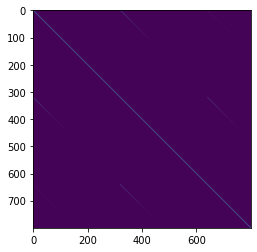

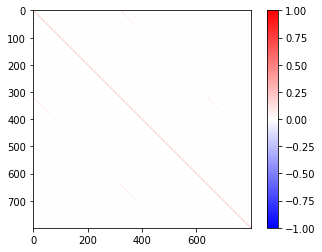

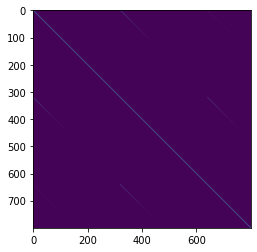

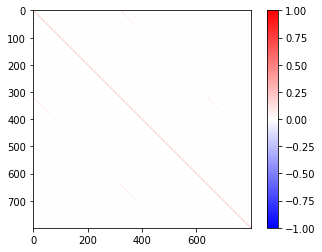

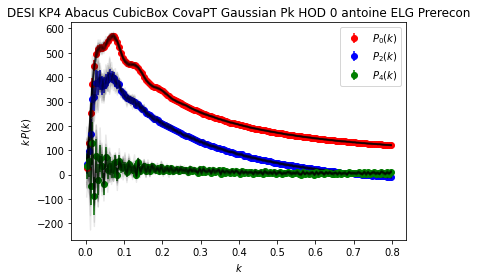

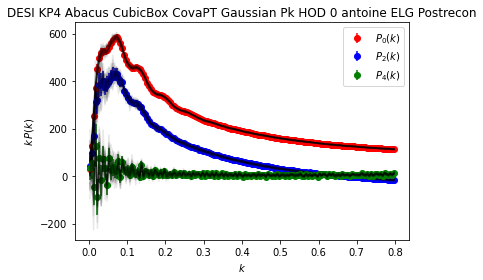

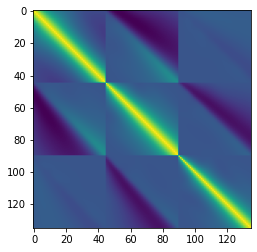

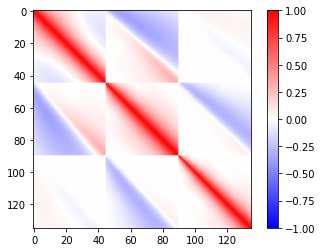

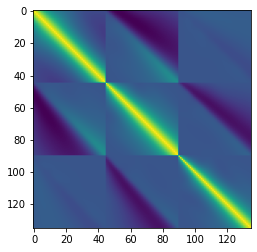

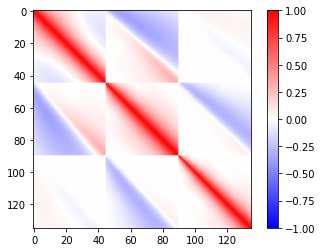

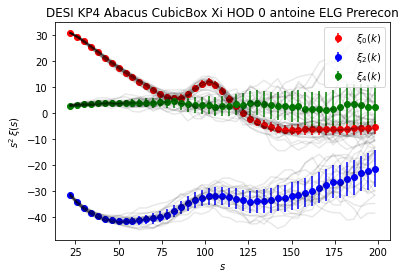

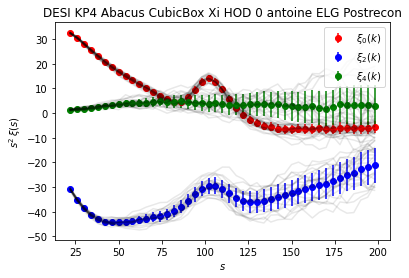

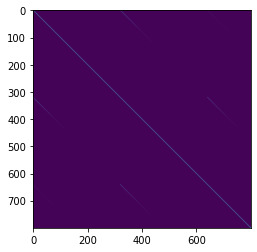

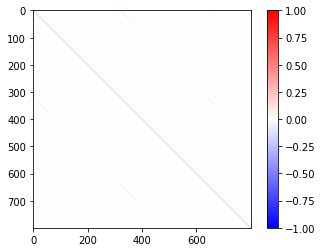

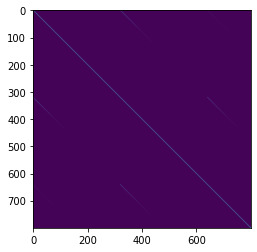

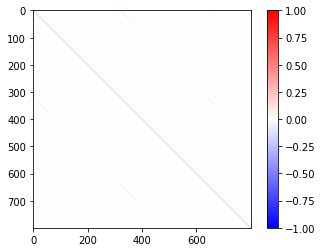

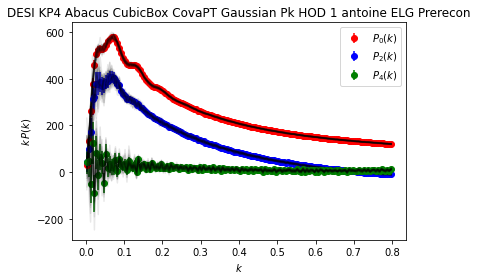

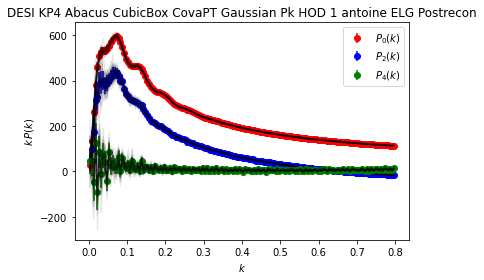

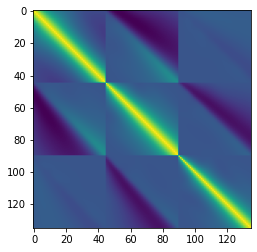

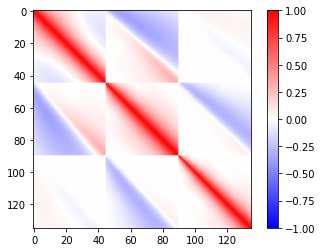

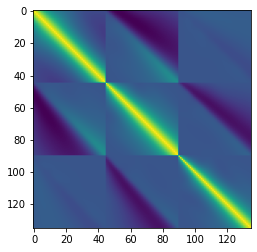

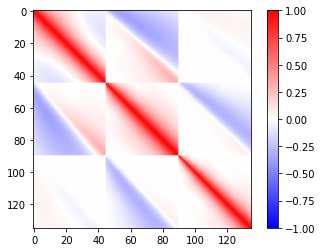

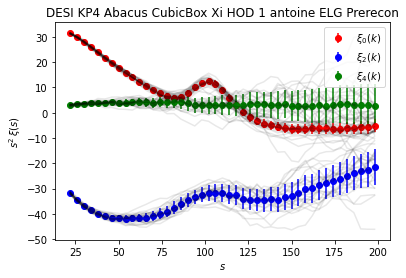

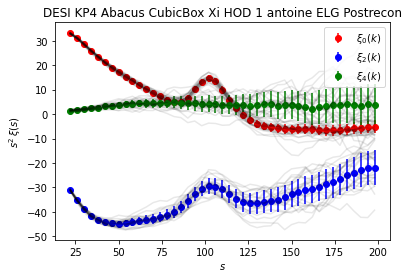

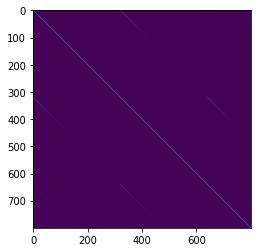

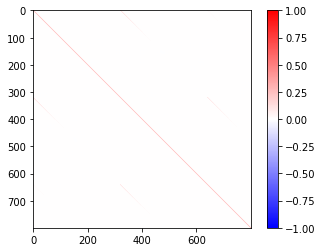

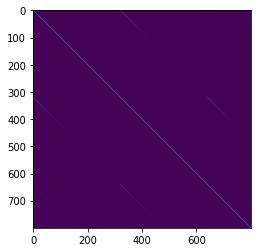

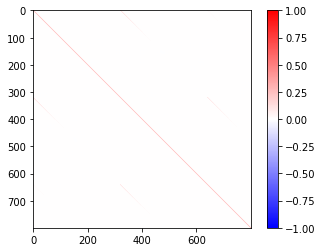

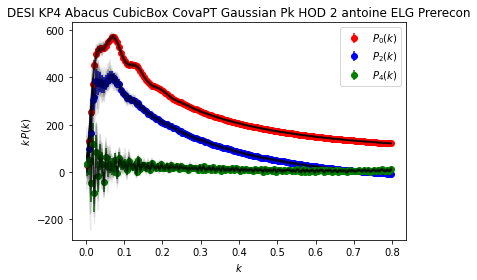

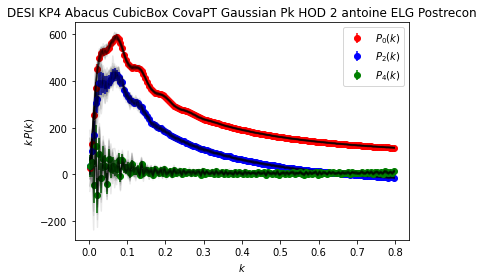

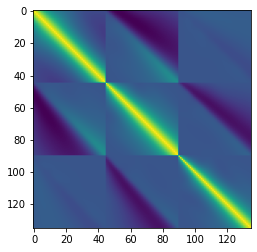

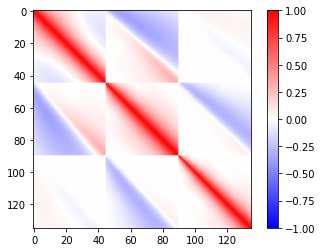

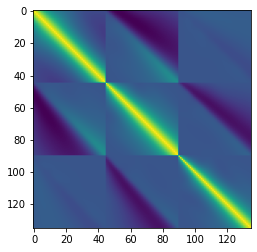

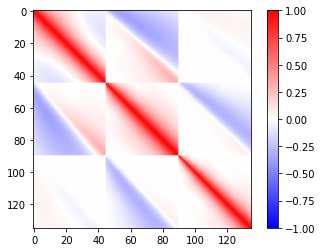

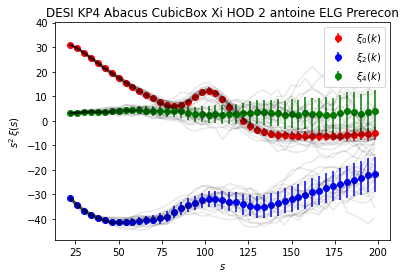

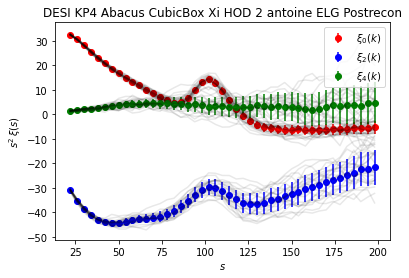

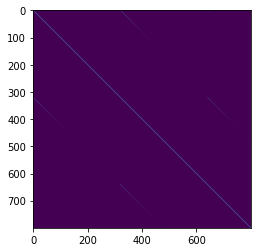

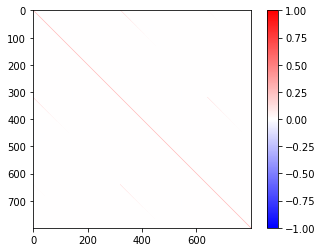

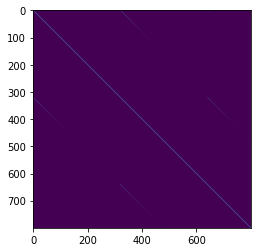

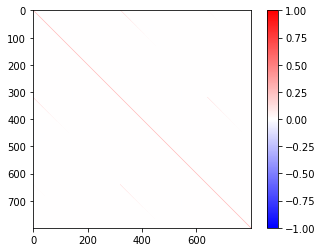

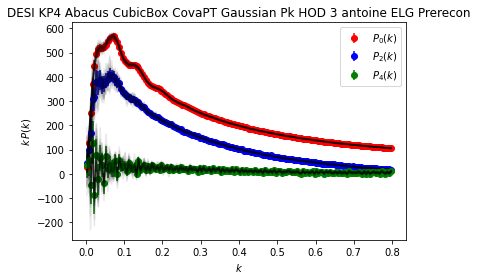

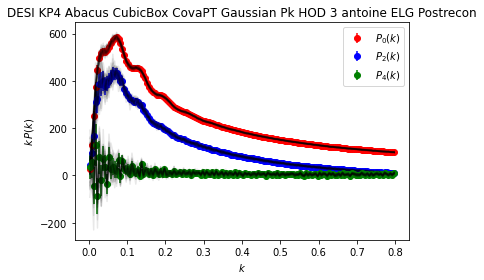

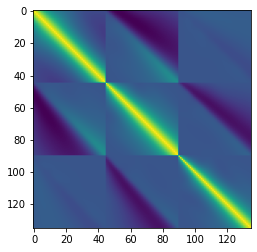

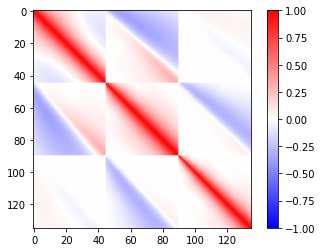

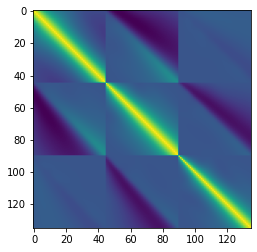

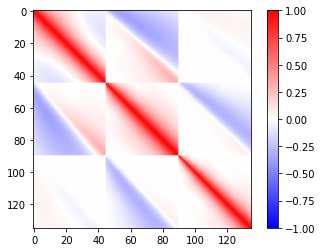

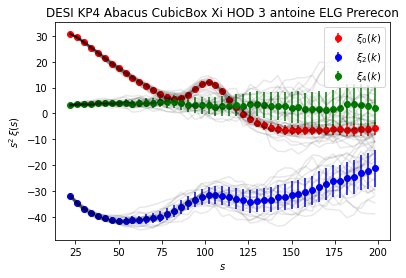

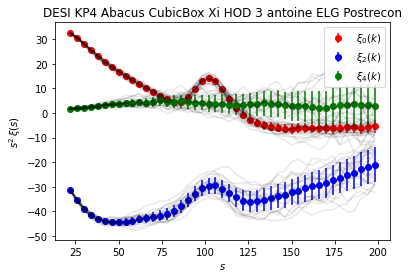

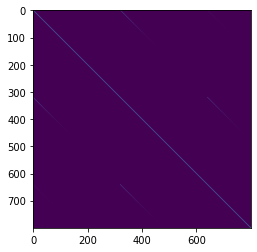

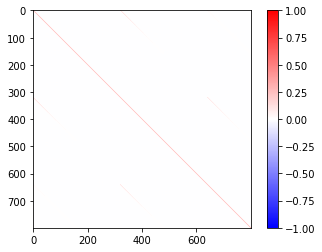

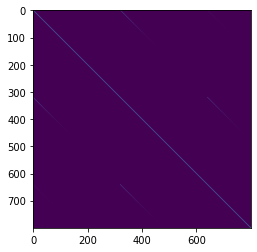

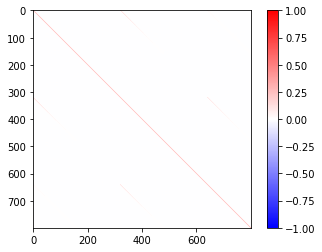

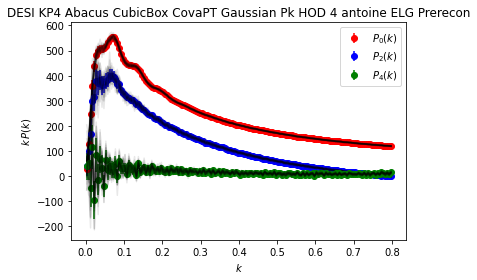

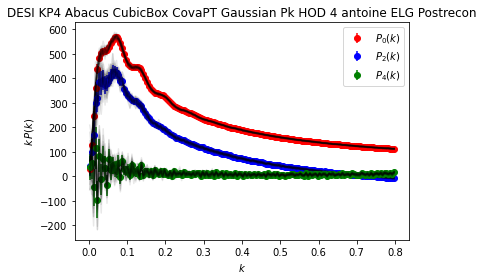

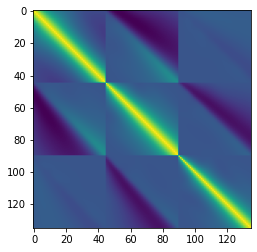

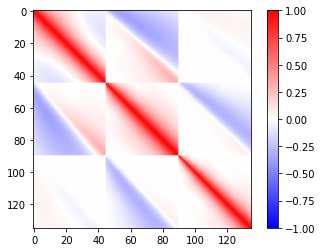

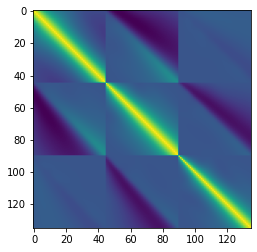

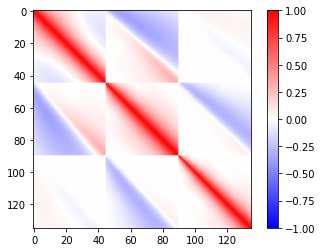

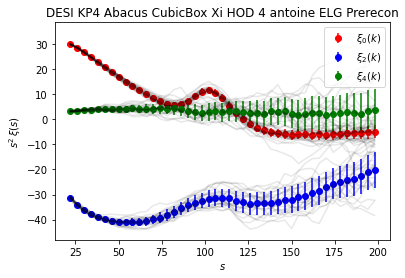

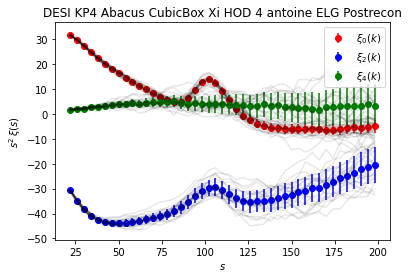

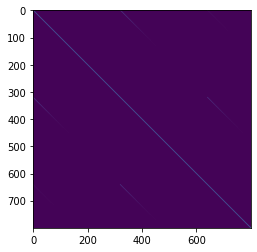

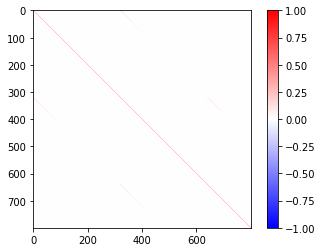

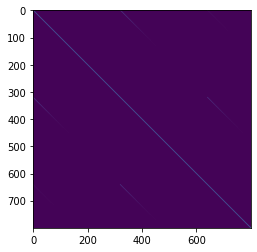

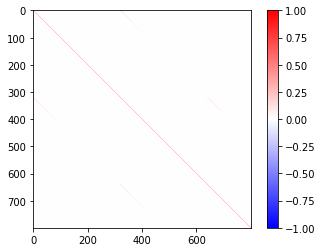

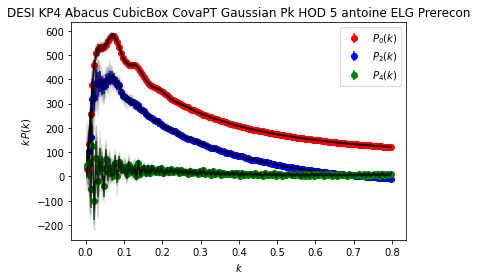

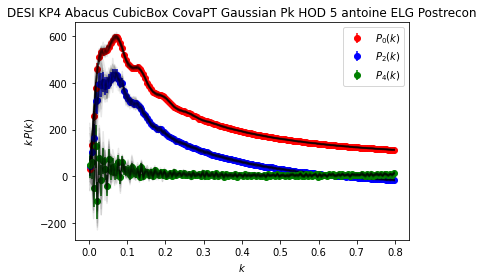

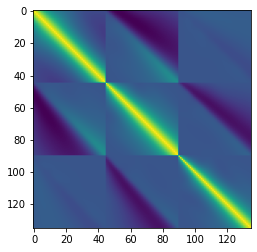

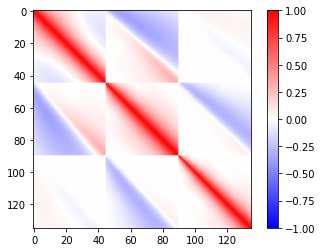

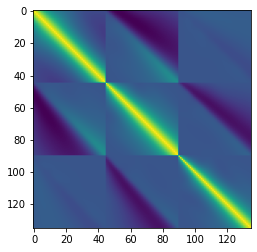

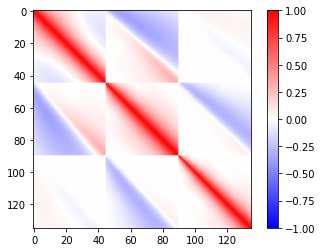

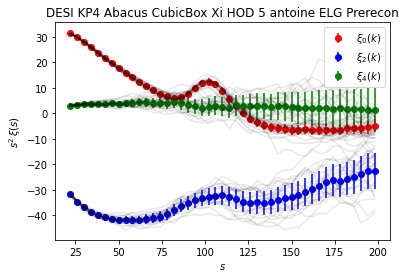

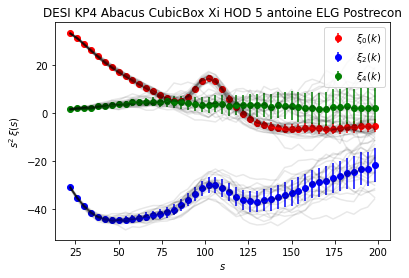

In [6]:
# Loop over tracers
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/"
path_ezmock = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/EZMocks/"
path_pk_cov = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/CovaPT/"
path_xi_cov = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/RascalC/"
mock = 'antoine'

# Dictionary containing z for the tracers
reds = {"ELG": [1.1]}
for hod in range(6):
    for tracer in ["ELG"]:
        for i, z in enumerate(reds[tracer]):

            # Power Spectrum --------------------------------------------------------------------------------
            # ANTOINE SETTINGS 
            pre_file = path_abacus + tracer + "/Pk/Pre/HOD/antoine_hods"
            pre_cov_file = path_pk_cov + "AnalyticCov_Gaussian_Pk_Abacus_CubicBox_hod"+str(hod)+".txt"  
            post_file = path_abacus + tracer + "/Pk/Post/HOD/antoine_hods/txt_rebinned"
            post_cov_file = path_pk_cov + "AnalyticCov_Gaussian_Pk_Abacus_CubicBox_hod"+str(hod)+".txt"   
            name = f"DESI KP4 Abacus CubicBox CovaPT Gaussian Pk HOD " + str(hod) + ' ' + mock + ' ' + tracer 
            data = collect_pk_data(pre_file, post_file, pre_cov_file, post_cov_file, None, z, "Pk_Abacus_CubicBox_ph0",
                                   "AbacusSummit_base_c000_ph0", hod, name, antoine=True)
            plot_pk(data) # Plot the data to check things

            # Correlation Function --------------------------------------------------------------------------------
            pre_file = path_abacus + tracer + f"/Xi/Pre/HOD/"+mock+"_hods/rebinned"
            pre_cov_file = path_xi_cov + "xi024_ELG_antoine-HOD0_lin4_s20-200_cov_RascalC_Gaussian.txt"  
            post_file = path_abacus + tracer + "/Xi/Post/HOD/"+mock+"_hods/rebinned"
            post_cov_file = path_xi_cov + "xi024_ELG_antoine-HOD0_lin4_s20-200_cov_RascalC_Gaussian.txt"   
            name = f"DESI KP4 Abacus CubicBox Xi HOD " + str(hod) + ' ' + mock + ' ' + tracer
            data = collect_xi_data(pre_file, post_file, pre_cov_file, post_cov_file, z, "Xi_Abacus_CubicBox_ph0", "Xi_Abacus_CubicBox_ph0", hod, 
                                   name, RascalC=True)
            plot_xi(data) # Plot the data to check things

Sandy Mocks

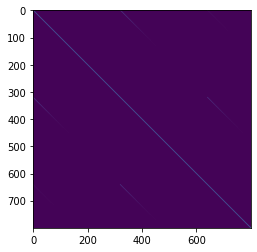

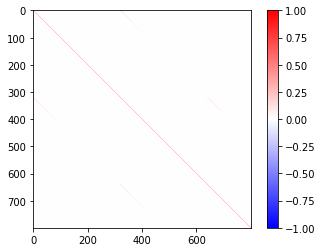

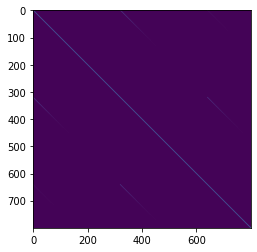

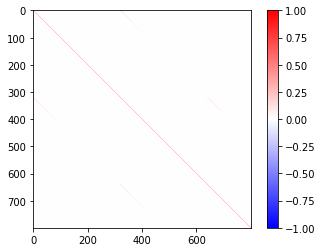

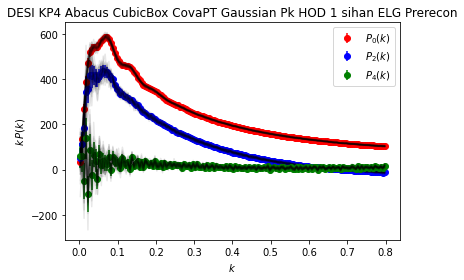

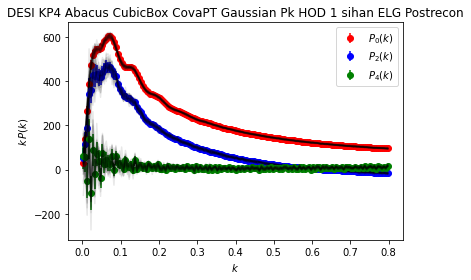

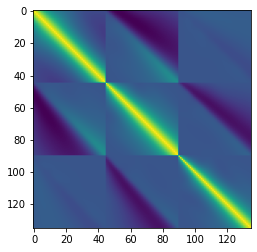

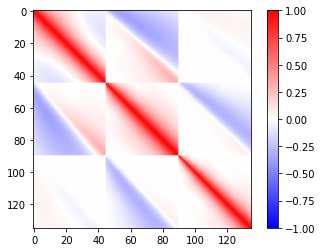

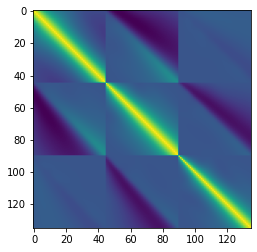

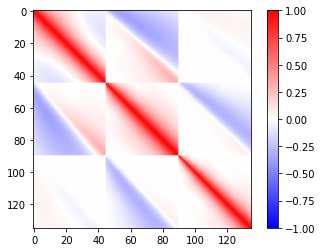

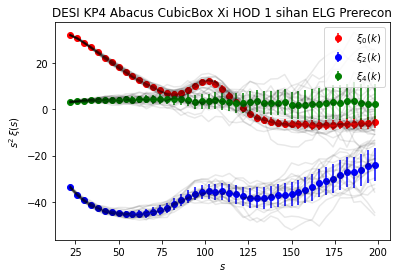

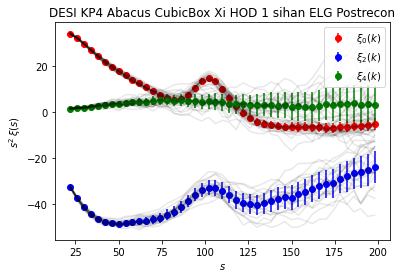

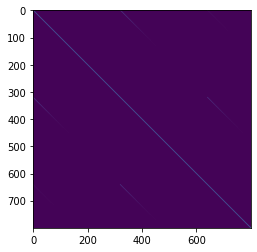

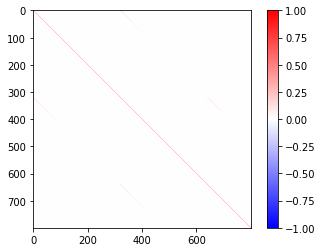

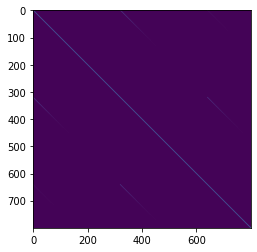

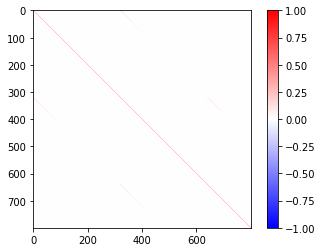

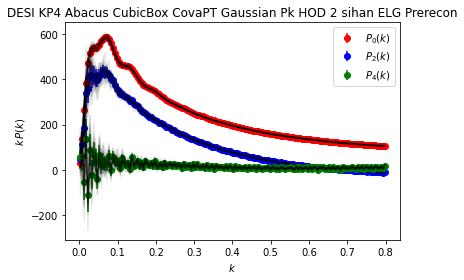

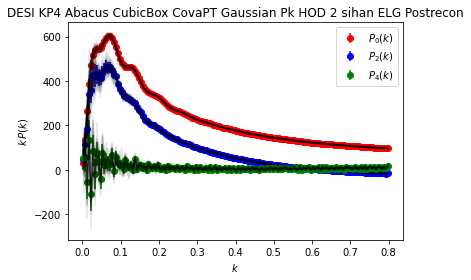

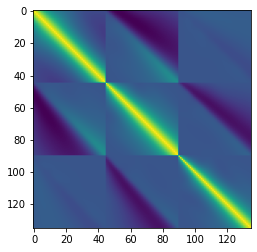

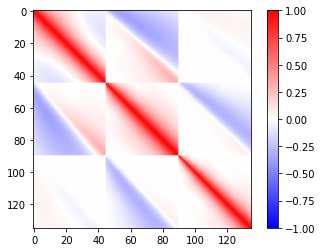

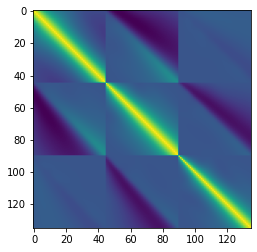

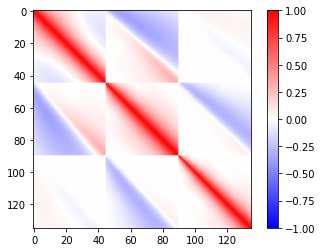

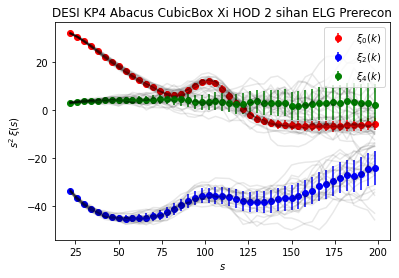

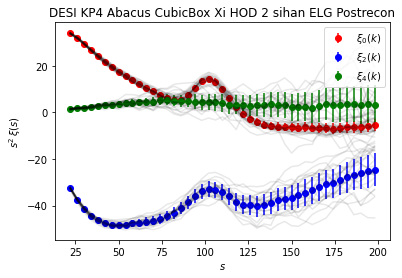

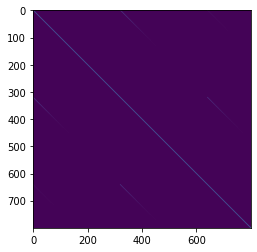

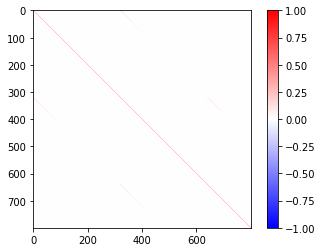

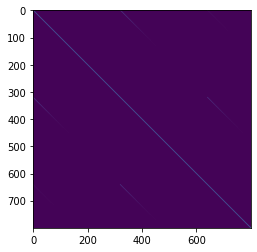

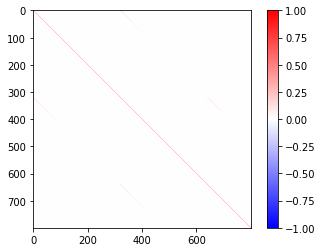

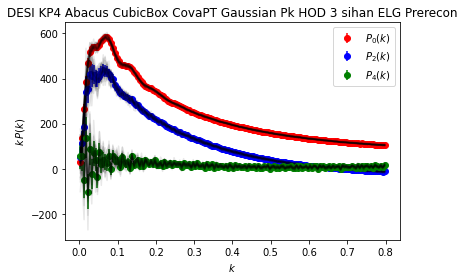

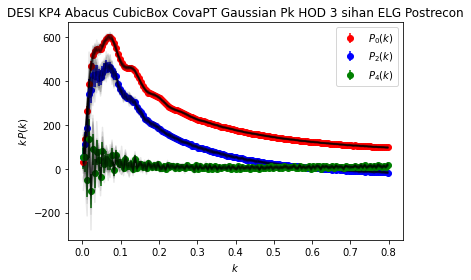

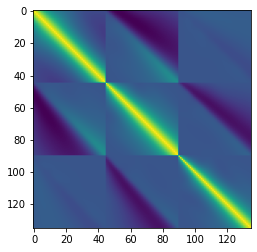

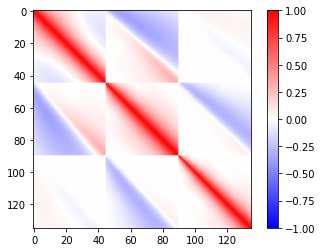

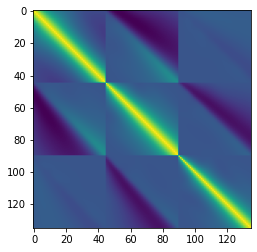

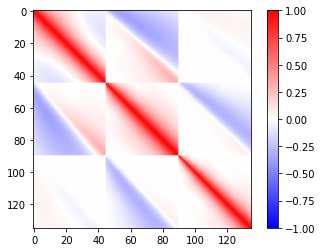

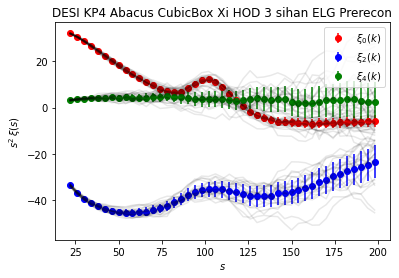

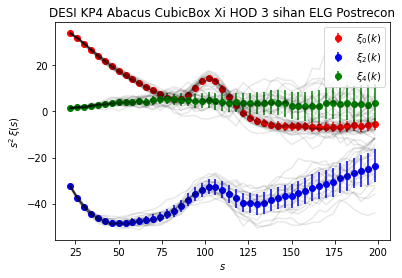

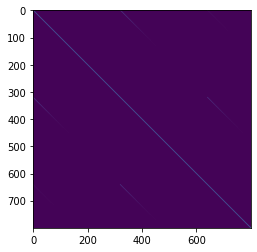

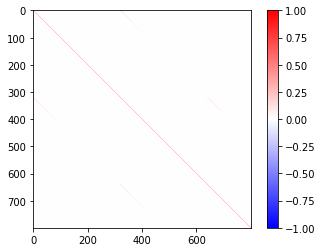

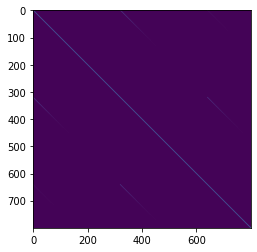

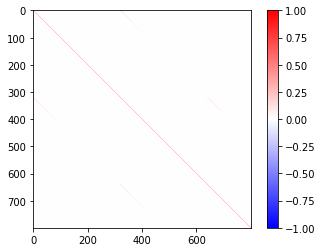

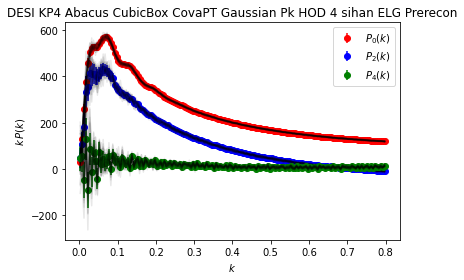

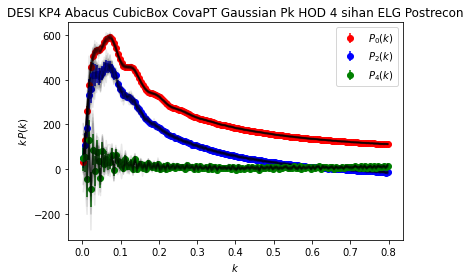

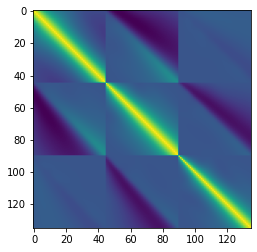

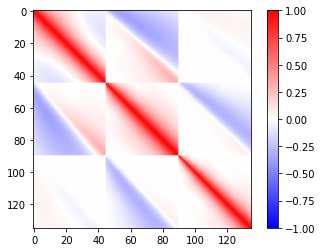

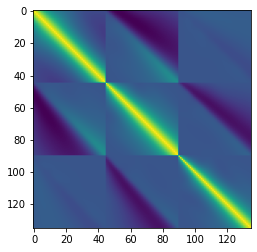

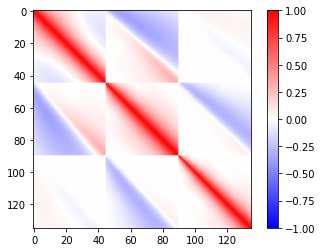

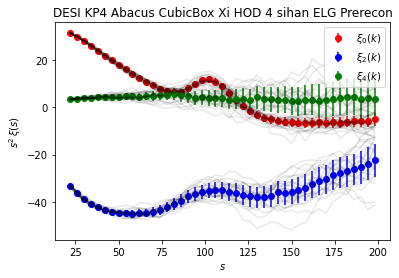

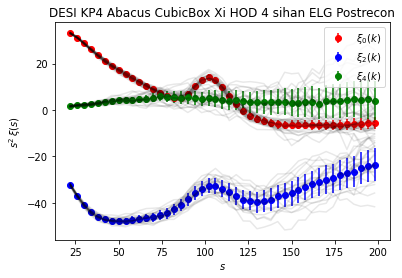

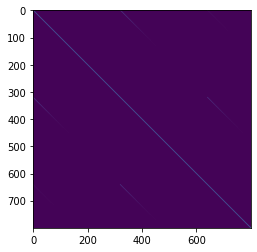

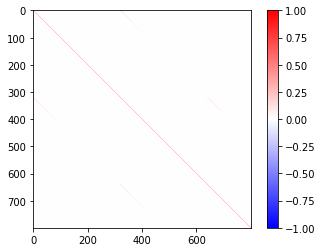

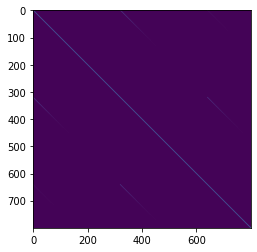

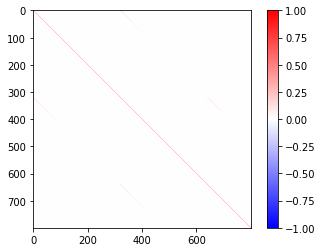

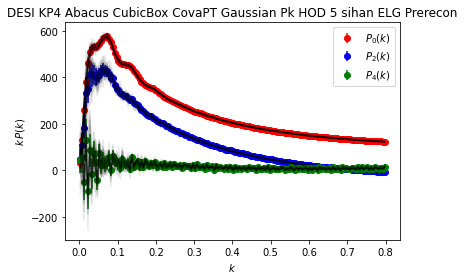

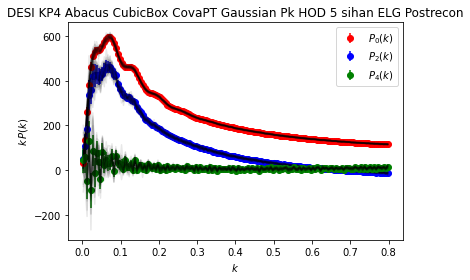

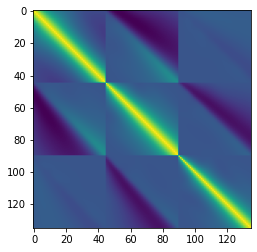

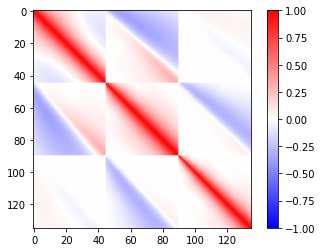

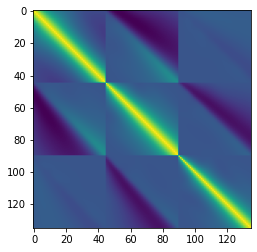

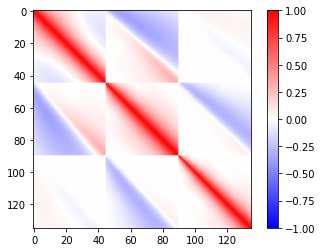

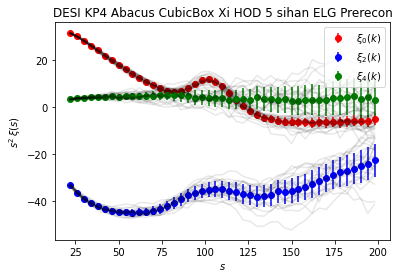

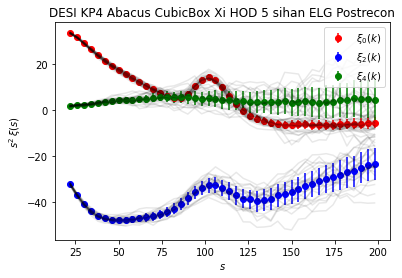

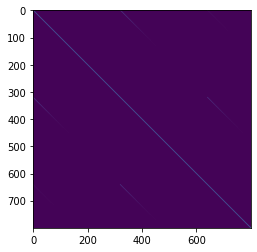

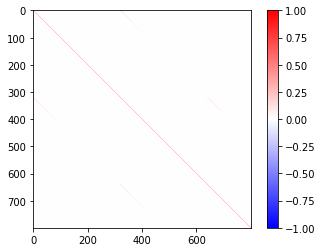

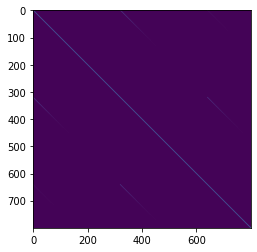

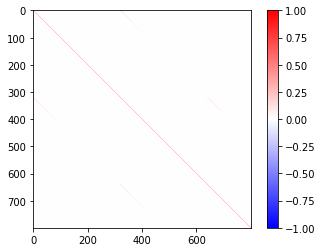

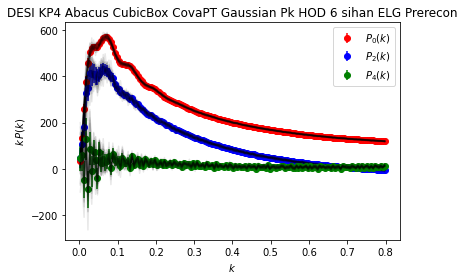

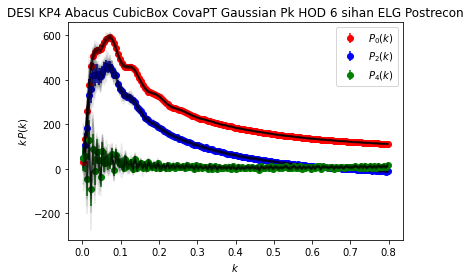

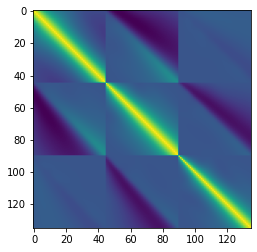

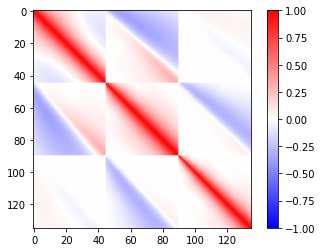

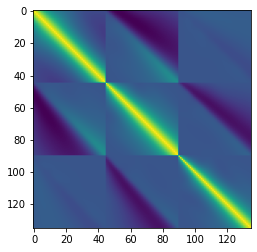

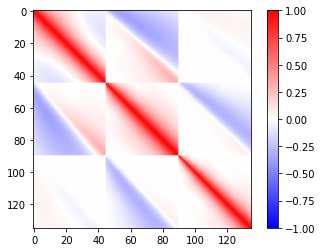

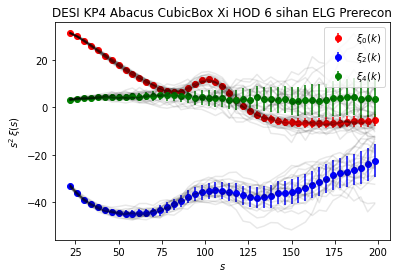

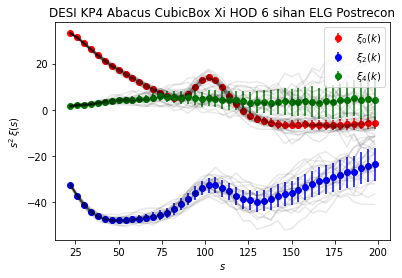

In [7]:
# Loop over tracers
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/"
path_ezmock = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/"
path_pk_cov = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/CovaPT/"
path_xi_cov = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/RascalC/"
mock = 'sihan'

# Dictionary containing z for the tracers
reds = {"ELG": [1.1]}

for hod in range(1,7):
    for tracer in ["ELG"]:
        for i, z in enumerate(reds[tracer]):

            # Power Spectrum --------------------------------------------------------------------------------
            # SIHAN SETTINGS 
            pre_file = path_abacus + tracer + "/Pk/Pre/HOD/sihan_hods/txt_rebinned"
            pre_cov_file = path_pk_cov + "AnalyticCov_Gaussian_Pk_Abacus_CubicBox_hod"+str(5)+".txt"  
            post_file = path_abacus + tracer + "/Pk/Post/HOD/sihan_hods/txt_rebinned"
            post_cov_file = path_pk_cov + "AnalyticCov_Gaussian_Pk_Abacus_CubicBox_hod"+str(5)+".txt"   
            name = f"DESI KP4 Abacus CubicBox CovaPT Gaussian Pk HOD " + str(hod) + ' ' + mock + ' ' + tracer 
            data = collect_pk_data(pre_file, post_file, pre_cov_file, post_cov_file, None, z, "AbacusSummit_base_c000_ph0",
                                   "AbacusSummit_base_c000_ph0", hod, name, antoine=False)
            plot_pk(data) # Plot the data to check things

            # Correlation Function --------------------------------------------------------------------------------
            pre_file = path_abacus + tracer + f"/Xi/Pre/HOD/"+mock+"_hods/rebinned"
            pre_cov_file = path_xi_cov + "xi024_ELG_antoine-HOD0_lin4_s20-200_cov_RascalC_Gaussian.txt"  
            post_file = path_abacus + tracer + "/Xi/Post/HOD/"+mock+"_hods/rebinned"
            post_cov_file = path_xi_cov + "xi024_ELG_antoine-HOD0_lin4_s20-200_cov_RascalC_Gaussian.txt"   
            name = f"DESI KP4 Abacus CubicBox Xi HOD " + str(hod) + ' ' + mock + ' ' + tracer
            data = collect_xi_data(pre_file, post_file, pre_cov_file, post_cov_file, z, "Xi_Abacus_CubicBox_ph0", "Xi_Abacus_CubicBox_ph0", hod, 
                                   name, RascalC=True)
            plot_xi(data) # Plot the data to check things

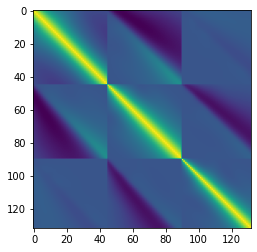

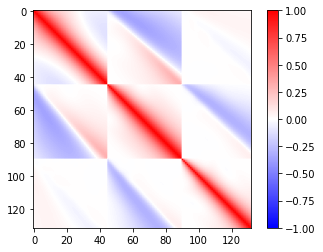

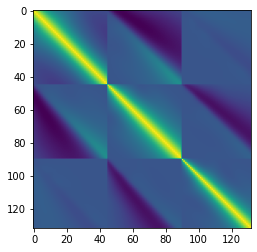

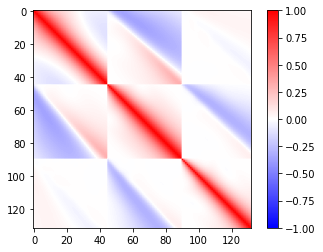

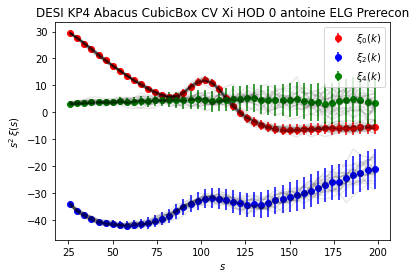

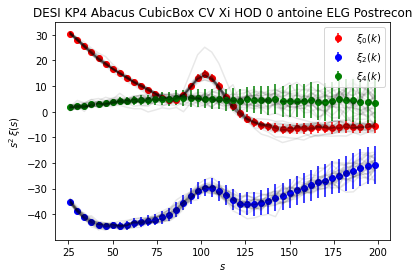

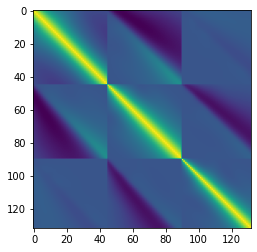

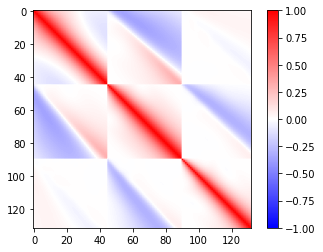

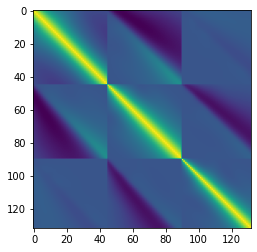

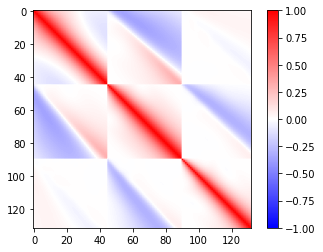

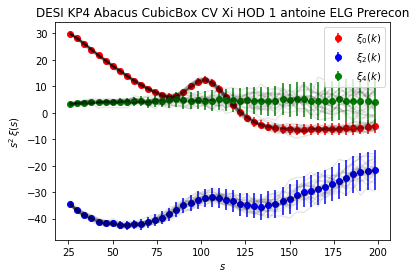

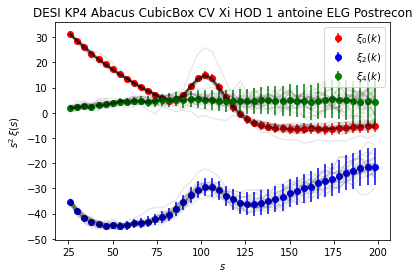

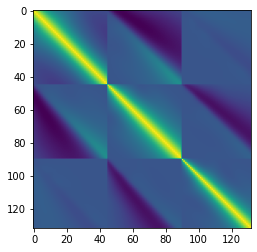

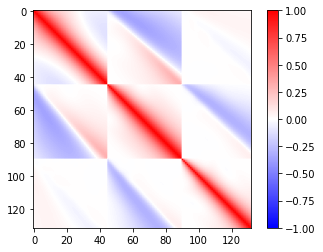

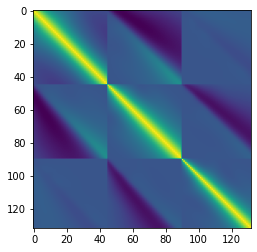

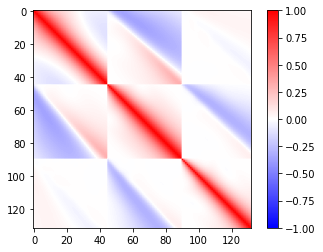

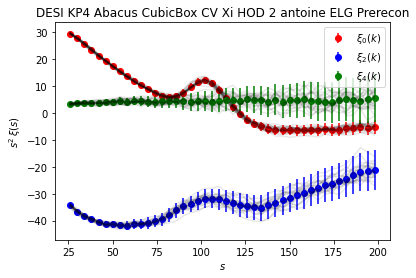

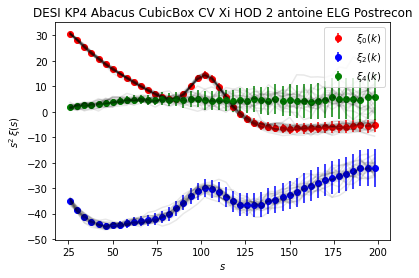

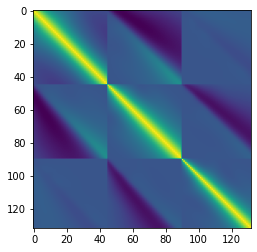

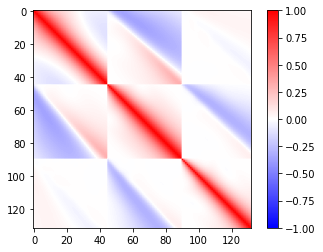

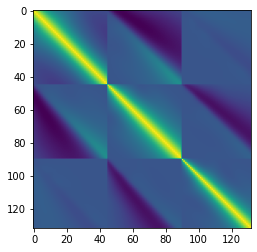

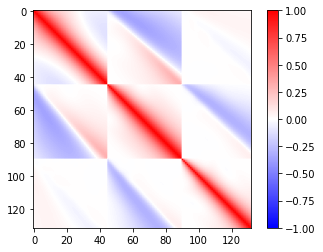

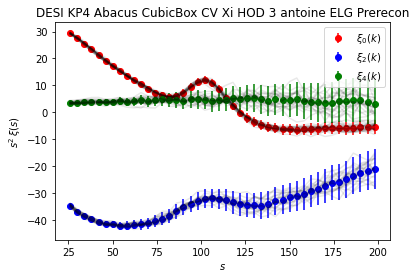

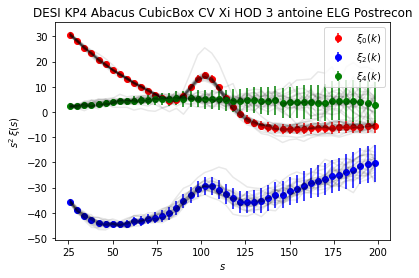

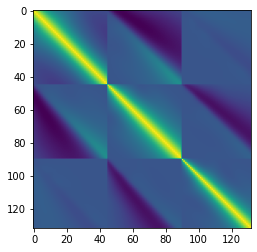

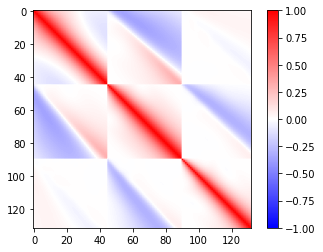

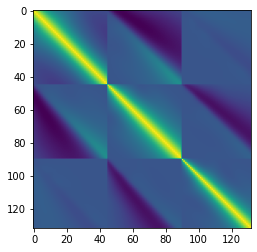

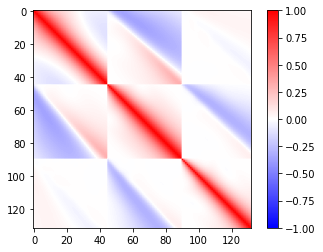

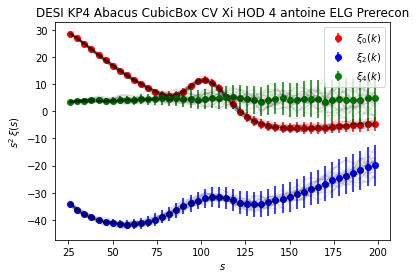

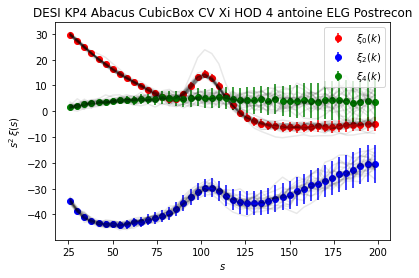

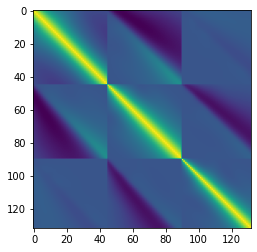

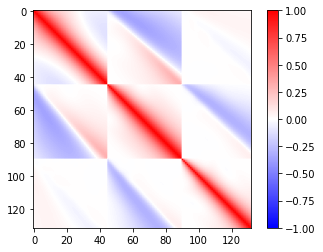

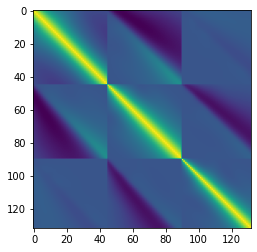

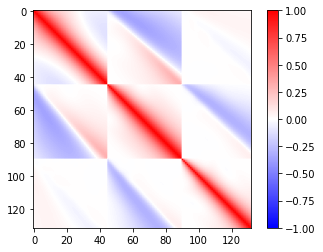

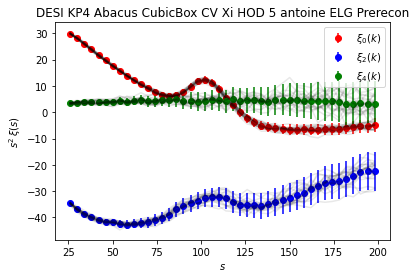

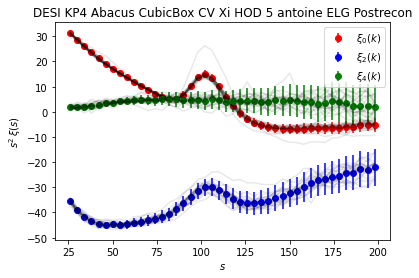

In [8]:
# Loop over tracers
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/"
path_ezmock = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/"
path_pk_cov = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/CovaPT/"
path_xi_cov = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/RascalC/"
mock = 'antoine'

# Dictionary containing z for the tracers
reds = {"ELG": [1.1]}

for hod in range(6):
    for tracer in ["ELG"]:
        for i, z in enumerate(reds[tracer]):
            # Correlation Function --------------------------------------------------------------------------------
            pre_file = path_abacus + tracer + f"/Xi/Pre/HOD/rebinned_CV/antoine/"
            pre_cov_file = path_xi_cov + "xi024_ELG_antoine-HOD0_lin4_s20-200_cov_RascalC_Gaussian.txt"  
            post_file = path_abacus + tracer + f"/Xi/Post/HOD/rebinned_CV/antoine/"
            post_cov_file = path_xi_cov + "xi024_ELG_antoine-HOD0_lin4_s20-200_cov_RascalC_Gaussian.txt"   
            name = f"DESI KP4 Abacus CubicBox CV Xi HOD " + str(hod) + ' ' + mock + ' ' + tracer
            data = collect_xi_data(pre_file, post_file, pre_cov_file, post_cov_file, z, 
                                   "Xi_Abacus_CubicBox_ph0", "Xi_Abacus_CubicBox_ph0", hod, 
                                   name, RascalC=True, CV=True)
            plot_xi(data) # Plot the data to check things

CV Pk

num_gal: 7858549.0 nbar_gal: 0.000982318625 Shot-Noise: 1068.8996149289137
num_gal: 7924237.0 nbar_gal: 0.000990529625 Shot-Noise: 1060.0389665276289
num_gal: 7943229.0 nbar_gal: 0.000992903625 Shot-Noise: 1057.504448128085
num_gal: 7945531.0 nbar_gal: 0.000993191375 Shot-Noise: 1057.1980651765123
num_gal: 7948938.0 nbar_gal: 0.00099361725 Shot-Noise: 1056.7449387578567
num_gal: 8032395.0 nbar_gal: 0.001004049375 Shot-Noise: 1045.7653041216226
num_gal: 7895578.0 nbar_gal: 0.00098694725 Shot-Noise: 1063.8866464241123
num_gal: 7978872.0 nbar_gal: 0.000997359 Shot-Noise: 1052.7803930179605
num_gal: 7966752.0 nbar_gal: 0.000995844 Shot-Noise: 1054.3820116403772
num_gal: 8006531.0 nbar_gal: 0.001000816375 Shot-Noise: 1049.1435054707213
num_gal: 7854288.0 nbar_gal: 0.000981786 Shot-Noise: 1069.4794996058206
num_gal: 7919619.0 nbar_gal: 0.000989952375 Shot-Noise: 1060.6570846400566
num_gal: 7942399.0 nbar_gal: 0.000992799875 Shot-Noise: 1057.6149599132455
num_gal: 8074816.0 nbar_gal: 0.001009

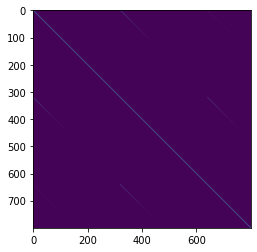

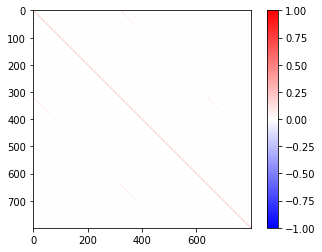

num_gal: 7858549.0 nbar_gal: 0.000982318625 Shot-Noise: 1068.8996149289137
num_gal: 7924237.0 nbar_gal: 0.000990529625 Shot-Noise: 1060.0389665276289
num_gal: 7943229.0 nbar_gal: 0.000992903625 Shot-Noise: 1057.504448128085
num_gal: 7945531.0 nbar_gal: 0.000993191375 Shot-Noise: 1057.1980651765123
num_gal: 7948938.0 nbar_gal: 0.00099361725 Shot-Noise: 1056.7449387578567
num_gal: 8032395.0 nbar_gal: 0.001004049375 Shot-Noise: 1045.7653041216226
num_gal: 7895578.0 nbar_gal: 0.00098694725 Shot-Noise: 1063.8866464241123
num_gal: 7978872.0 nbar_gal: 0.000997359 Shot-Noise: 1052.7803930179605
num_gal: 7966752.0 nbar_gal: 0.000995844 Shot-Noise: 1054.3820116403772
num_gal: 8006531.0 nbar_gal: 0.001000816375 Shot-Noise: 1049.1435054707213
num_gal: 7854288.0 nbar_gal: 0.000981786 Shot-Noise: 1069.4794996058206
num_gal: 7919619.0 nbar_gal: 0.000989952375 Shot-Noise: 1060.6570846400566
num_gal: 7942399.0 nbar_gal: 0.000992799875 Shot-Noise: 1057.6149599132455
num_gal: 8074816.0 nbar_gal: 0.001009

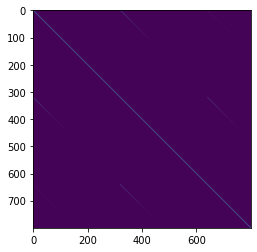

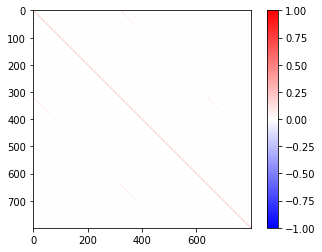

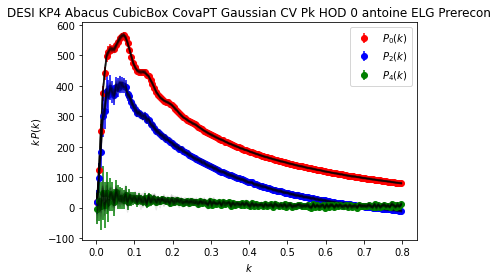

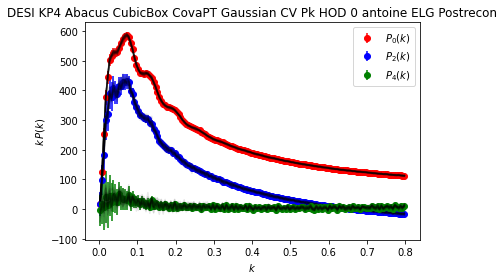

num_gal: 8035737.0 nbar_gal: 0.001004467125 Shot-Noise: 1045.3303785327967
num_gal: 8084400.0 nbar_gal: 0.00101055 Shot-Noise: 1039.038147543417
num_gal: 7902009.0 nbar_gal: 0.000987751125 Shot-Noise: 1063.0208090119868
num_gal: 7907316.0 nbar_gal: 0.0009884145 Shot-Noise: 1062.3073619417764
num_gal: 7935829.0 nbar_gal: 0.000991978625 Shot-Noise: 1058.490549632559
num_gal: 7980394.0 nbar_gal: 0.00099754925 Shot-Noise: 1052.579609477928
num_gal: 8078301.0 nbar_gal: 0.001009787625 Shot-Noise: 1039.8226062633714
num_gal: 7945353.0 nbar_gal: 0.000993169125 Shot-Noise: 1057.2217496189282
num_gal: 7944625.0 nbar_gal: 0.000993078125 Shot-Noise: 1057.3186273738534
num_gal: 7993722.0 nbar_gal: 0.00099921525 Shot-Noise: 1050.8246346320275
num_gal: 8032202.0 nbar_gal: 0.00100402525 Shot-Noise: 1045.790432063337
num_gal: 7907416.0 nbar_gal: 0.000988427 Shot-Noise: 1062.2939276243972
num_gal: 7926772.0 nbar_gal: 0.0009908465 Shot-Noise: 1059.6999636169678
num_gal: 8019551.0 nbar_gal: 0.001002443875

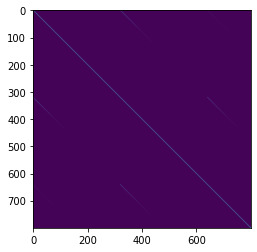

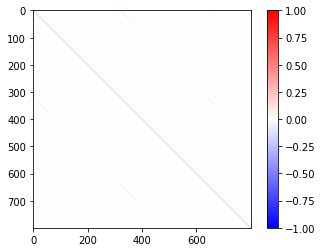

num_gal: 8035737.0 nbar_gal: 0.001004467125 Shot-Noise: 1045.3303785327967
num_gal: 8084400.0 nbar_gal: 0.00101055 Shot-Noise: 1039.038147543417
num_gal: 7902009.0 nbar_gal: 0.000987751125 Shot-Noise: 1063.0208090119868
num_gal: 7907316.0 nbar_gal: 0.0009884145 Shot-Noise: 1062.3073619417764
num_gal: 7935829.0 nbar_gal: 0.000991978625 Shot-Noise: 1058.490549632559
num_gal: 7980394.0 nbar_gal: 0.00099754925 Shot-Noise: 1052.579609477928
num_gal: 8078301.0 nbar_gal: 0.001009787625 Shot-Noise: 1039.8226062633714
num_gal: 7945353.0 nbar_gal: 0.000993169125 Shot-Noise: 1057.2217496189282
num_gal: 7944625.0 nbar_gal: 0.000993078125 Shot-Noise: 1057.3186273738534
num_gal: 7993722.0 nbar_gal: 0.00099921525 Shot-Noise: 1050.8246346320275
num_gal: 8032202.0 nbar_gal: 0.00100402525 Shot-Noise: 1045.790432063337
num_gal: 7907416.0 nbar_gal: 0.000988427 Shot-Noise: 1062.2939276243972
num_gal: 7926772.0 nbar_gal: 0.0009908465 Shot-Noise: 1059.6999636169678
num_gal: 8019551.0 nbar_gal: 0.001002443875

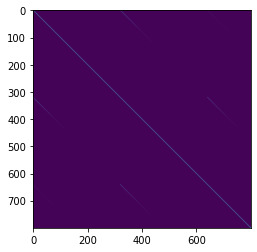

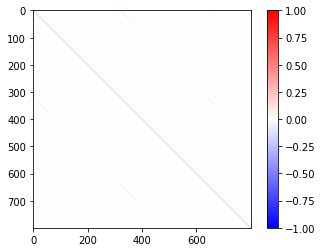

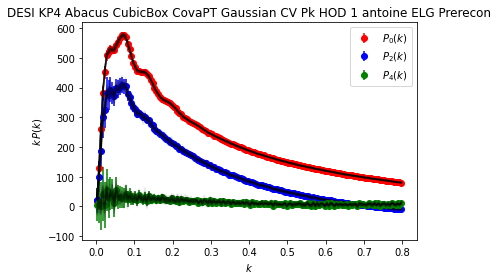

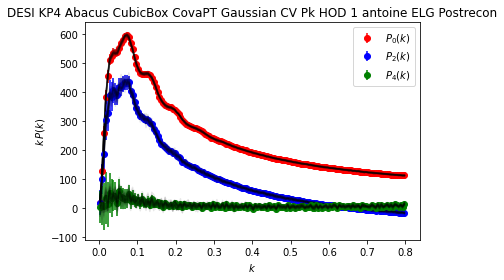

num_gal: 7890234.0 nbar_gal: 0.00098627925 Shot-Noise: 1064.6072093679352
num_gal: 7983683.0 nbar_gal: 0.000997960375 Shot-Noise: 1052.1459832510884
num_gal: 7984684.0 nbar_gal: 0.0009980855 Shot-Noise: 1052.0140809579939
num_gal: 7986267.0 nbar_gal: 0.000998283375 Shot-Noise: 1051.8055557120742
num_gal: 7972751.0 nbar_gal: 0.000996593875 Shot-Noise: 1053.5886546563413
num_gal: 8029019.0 nbar_gal: 0.001003627375 Shot-Noise: 1046.2050220581118
num_gal: 7945673.0 nbar_gal: 0.000993209125 Shot-Noise: 1057.1791716069865
num_gal: 8033594.0 nbar_gal: 0.00100419925 Shot-Noise: 1045.609225459987
num_gal: 7998521.0 nbar_gal: 0.000999815125 Shot-Noise: 1050.19415464434
num_gal: 8030595.0 nbar_gal: 0.001003824375 Shot-Noise: 1045.9997048786547
num_gal: 7893825.0 nbar_gal: 0.000986728125 Shot-Noise: 1064.1229061956656
num_gal: 7960812.0 nbar_gal: 0.0009951015 Shot-Noise: 1055.1687440929393
num_gal: 7968258.0 nbar_gal: 0.00099603225 Shot-Noise: 1054.1827335410073
num_gal: 8050482.0 nbar_gal: 0.0010

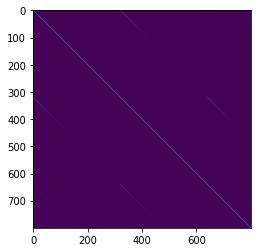

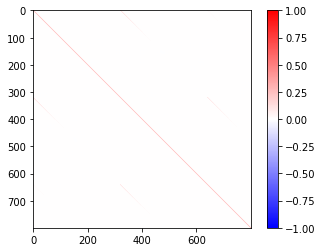

num_gal: 7890234.0 nbar_gal: 0.00098627925 Shot-Noise: 1064.6072093679352
num_gal: 7983683.0 nbar_gal: 0.000997960375 Shot-Noise: 1052.1459832510884
num_gal: 7984684.0 nbar_gal: 0.0009980855 Shot-Noise: 1052.0140809579939
num_gal: 7986267.0 nbar_gal: 0.000998283375 Shot-Noise: 1051.8055557120742
num_gal: 7972751.0 nbar_gal: 0.000996593875 Shot-Noise: 1053.5886546563413
num_gal: 8029019.0 nbar_gal: 0.001003627375 Shot-Noise: 1046.2050220581118
num_gal: 7945673.0 nbar_gal: 0.000993209125 Shot-Noise: 1057.1791716069865
num_gal: 8033594.0 nbar_gal: 0.00100419925 Shot-Noise: 1045.609225459987
num_gal: 7998521.0 nbar_gal: 0.000999815125 Shot-Noise: 1050.19415464434
num_gal: 8030595.0 nbar_gal: 0.001003824375 Shot-Noise: 1045.9997048786547
num_gal: 7893825.0 nbar_gal: 0.000986728125 Shot-Noise: 1064.1229061956656
num_gal: 7960812.0 nbar_gal: 0.0009951015 Shot-Noise: 1055.1687440929393
num_gal: 7968258.0 nbar_gal: 0.00099603225 Shot-Noise: 1054.1827335410073
num_gal: 8050482.0 nbar_gal: 0.0010

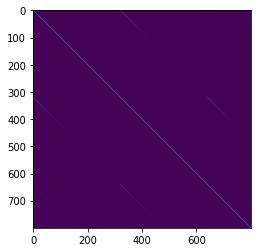

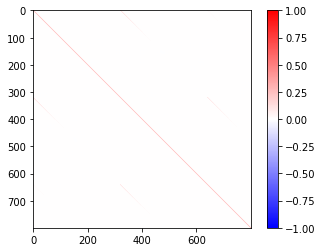

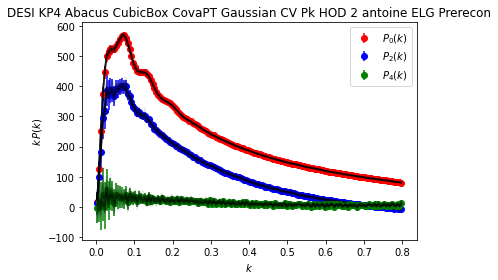

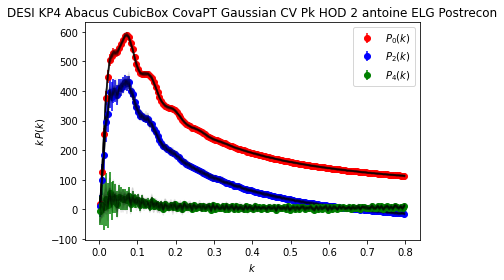

num_gal: 7565782.0 nbar_gal: 0.00094572275 Shot-Noise: 1110.2619663109513
num_gal: 7626024.0 nbar_gal: 0.000953253 Shot-Noise: 1101.491419381843
num_gal: 7644161.0 nbar_gal: 0.000955520125 Shot-Noise: 1098.8779540357666
num_gal: 7646193.0 nbar_gal: 0.000955774125 Shot-Noise: 1098.585923740089
num_gal: 7649129.0 nbar_gal: 0.000956141125 Shot-Noise: 1098.1642485046336
num_gal: 7726954.0 nbar_gal: 0.00096586925 Shot-Noise: 1087.1036633581616
num_gal: 7598962.0 nbar_gal: 0.00094987025 Shot-Noise: 1105.4141341935913
num_gal: 7677372.0 nbar_gal: 0.0009596715 Shot-Noise: 1094.1243956916508
num_gal: 7666597.0 nbar_gal: 0.000958324625 Shot-Noise: 1095.6621301471828
num_gal: 7703461.0 nbar_gal: 0.000962932625 Shot-Noise: 1090.4189688245322
num_gal: 7562149.0 nbar_gal: 0.000945268625 Shot-Noise: 1110.7953572456718
num_gal: 7622530.0 nbar_gal: 0.00095281625 Shot-Noise: 1101.996318807535
num_gal: 7644066.0 nbar_gal: 0.00095550825 Shot-Noise: 1098.8916108259662
num_gal: 7766401.0 nbar_gal: 0.0009708

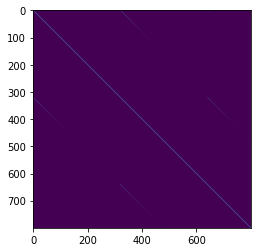

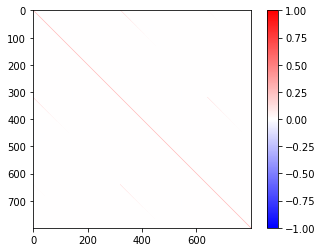

num_gal: 7565782.0 nbar_gal: 0.00094572275 Shot-Noise: 1110.2619663109513
num_gal: 7626024.0 nbar_gal: 0.000953253 Shot-Noise: 1101.491419381843
num_gal: 7644161.0 nbar_gal: 0.000955520125 Shot-Noise: 1098.8779540357666
num_gal: 7646193.0 nbar_gal: 0.000955774125 Shot-Noise: 1098.585923740089
num_gal: 7649129.0 nbar_gal: 0.000956141125 Shot-Noise: 1098.1642485046336
num_gal: 7726954.0 nbar_gal: 0.00096586925 Shot-Noise: 1087.1036633581616
num_gal: 7598962.0 nbar_gal: 0.00094987025 Shot-Noise: 1105.4141341935913
num_gal: 7677372.0 nbar_gal: 0.0009596715 Shot-Noise: 1094.1243956916508
num_gal: 7666597.0 nbar_gal: 0.000958324625 Shot-Noise: 1095.6621301471828
num_gal: 7703461.0 nbar_gal: 0.000962932625 Shot-Noise: 1090.4189688245322
num_gal: 7562149.0 nbar_gal: 0.000945268625 Shot-Noise: 1110.7953572456718
num_gal: 7622530.0 nbar_gal: 0.00095281625 Shot-Noise: 1101.996318807535
num_gal: 7644066.0 nbar_gal: 0.00095550825 Shot-Noise: 1098.8916108259662
num_gal: 7766401.0 nbar_gal: 0.0009708

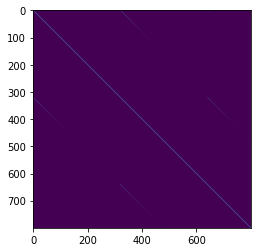

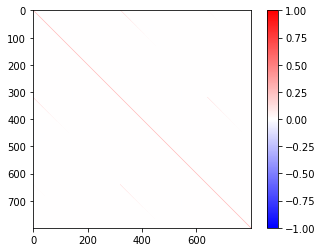

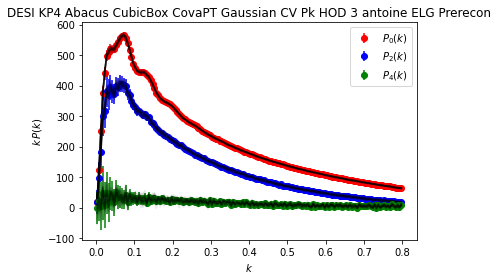

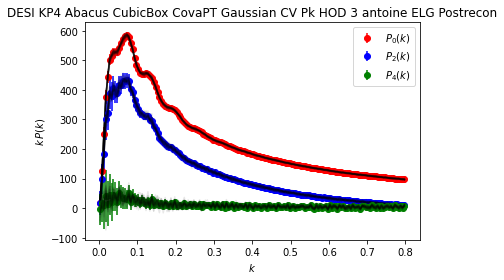

num_gal: 8132991.0 nbar_gal: 0.001016623875 Shot-Noise: 1032.8303572449547
num_gal: 8157417.0 nbar_gal: 0.001019677125 Shot-Noise: 1029.7377221245401
num_gal: 8156882.0 nbar_gal: 0.00101961025 Shot-Noise: 1029.805261373157
num_gal: 8158364.0 nbar_gal: 0.0010197955 Shot-Noise: 1029.6181930592948
num_gal: 8165314.0 nbar_gal: 0.00102066425 Shot-Noise: 1028.7418218086898
num_gal: 8152448.0 nbar_gal: 0.001019056 Shot-Noise: 1030.3653577428522
num_gal: 8160276.0 nbar_gal: 0.0010200345 Shot-Noise: 1029.3769475444215
num_gal: 8151953.0 nbar_gal: 0.001018994125 Shot-Noise: 1030.4279232228155
num_gal: 8148656.0 nbar_gal: 0.001018582 Shot-Noise: 1030.8448411615364
num_gal: 8138419.0 nbar_gal: 0.001017302375 Shot-Noise: 1032.141500701795
num_gal: 8134395.0 nbar_gal: 0.001016799375 Shot-Noise: 1032.652090290673
num_gal: 8162398.0 nbar_gal: 0.00102029975 Shot-Noise: 1029.1093377215864
num_gal: 8165918.0 nbar_gal: 0.00102073975 Shot-Noise: 1028.6657299277315
num_gal: 8127191.0 nbar_gal: 0.00101589887

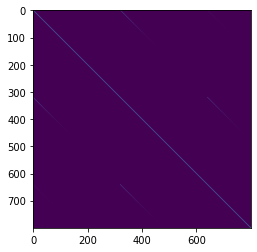

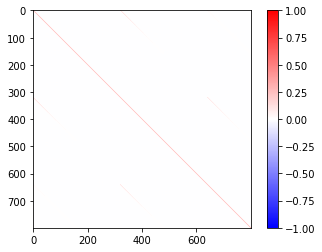

num_gal: 8132991.0 nbar_gal: 0.001016623875 Shot-Noise: 1032.8303572449547
num_gal: 8157417.0 nbar_gal: 0.001019677125 Shot-Noise: 1029.7377221245401
num_gal: 8156882.0 nbar_gal: 0.00101961025 Shot-Noise: 1029.805261373157
num_gal: 8158364.0 nbar_gal: 0.0010197955 Shot-Noise: 1029.6181930592948
num_gal: 8165314.0 nbar_gal: 0.00102066425 Shot-Noise: 1028.7418218086898
num_gal: 8152448.0 nbar_gal: 0.001019056 Shot-Noise: 1030.3653577428522
num_gal: 8160276.0 nbar_gal: 0.0010200345 Shot-Noise: 1029.3769475444215
num_gal: 8151953.0 nbar_gal: 0.001018994125 Shot-Noise: 1030.4279232228155
num_gal: 8148656.0 nbar_gal: 0.001018582 Shot-Noise: 1030.8448411615364
num_gal: 8138419.0 nbar_gal: 0.001017302375 Shot-Noise: 1032.141500701795
num_gal: 8134395.0 nbar_gal: 0.001016799375 Shot-Noise: 1032.652090290673
num_gal: 8162398.0 nbar_gal: 0.00102029975 Shot-Noise: 1029.1093377215864
num_gal: 8165918.0 nbar_gal: 0.00102073975 Shot-Noise: 1028.6657299277315
num_gal: 8127191.0 nbar_gal: 0.00101589887

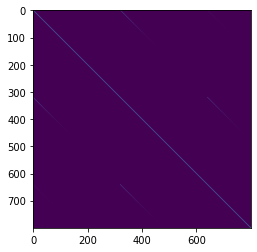

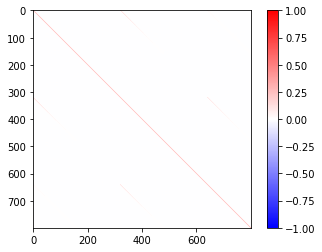

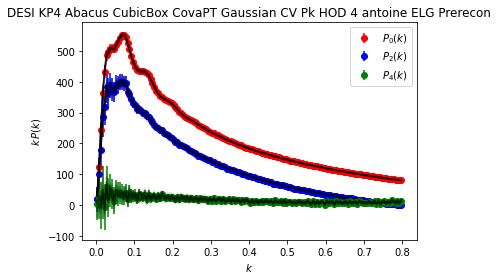

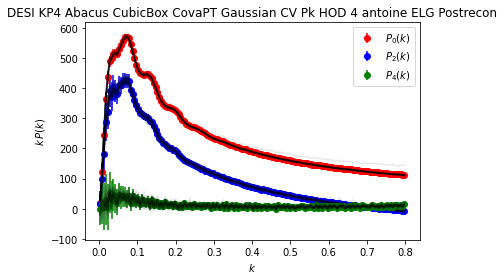

num_gal: 7996551.0 nbar_gal: 0.000999568875 Shot-Noise: 1050.4528764963795
num_gal: 8036837.0 nbar_gal: 0.001004604625 Shot-Noise: 1045.1873044084384
num_gal: 8057518.0 nbar_gal: 0.00100718975 Shot-Noise: 1042.5046521770105
num_gal: 8037805.0 nbar_gal: 0.001004725625 Shot-Noise: 1045.0614315724254
num_gal: 8029973.0 nbar_gal: 0.001003746625 Shot-Noise: 1046.0807277932317
num_gal: 7979463.0 nbar_gal: 0.000997432875 Shot-Noise: 1052.7024186965966
num_gal: 8011000.0 nbar_gal: 0.001001375 Shot-Noise: 1048.5582324304082
num_gal: 8052923.0 nbar_gal: 0.001006615375 Shot-Noise: 1043.0995056080878
num_gal: 8049128.0 nbar_gal: 0.001006141 Shot-Noise: 1043.5913057911366
num_gal: 7967540.0 nbar_gal: 0.0009959425 Shot-Noise: 1054.2777318971728
num_gal: 7994041.0 nbar_gal: 0.000999255125 Shot-Noise: 1050.782701764977
num_gal: 8028594.0 nbar_gal: 0.00100357425 Shot-Noise: 1046.2604037518897
num_gal: 8025986.0 nbar_gal: 0.00100324825 Shot-Noise: 1046.600380314643
num_gal: 7956319.0 nbar_gal: 0.0009945

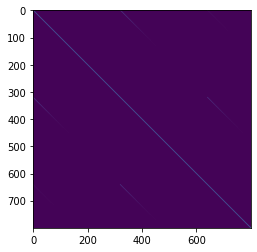

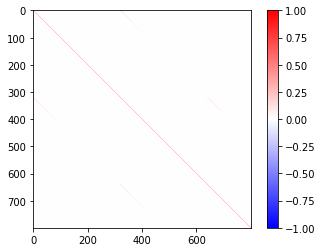

num_gal: 7996551.0 nbar_gal: 0.000999568875 Shot-Noise: 1050.4528764963795
num_gal: 8036837.0 nbar_gal: 0.001004604625 Shot-Noise: 1045.1873044084384
num_gal: 8057518.0 nbar_gal: 0.00100718975 Shot-Noise: 1042.5046521770105
num_gal: 8037805.0 nbar_gal: 0.001004725625 Shot-Noise: 1045.0614315724254
num_gal: 8029973.0 nbar_gal: 0.001003746625 Shot-Noise: 1046.0807277932317
num_gal: 7979463.0 nbar_gal: 0.000997432875 Shot-Noise: 1052.7024186965966
num_gal: 8011000.0 nbar_gal: 0.001001375 Shot-Noise: 1048.5582324304082
num_gal: 8052923.0 nbar_gal: 0.001006615375 Shot-Noise: 1043.0995056080878
num_gal: 8049128.0 nbar_gal: 0.001006141 Shot-Noise: 1043.5913057911366
num_gal: 7967540.0 nbar_gal: 0.0009959425 Shot-Noise: 1054.2777318971728
num_gal: 7994041.0 nbar_gal: 0.000999255125 Shot-Noise: 1050.782701764977
num_gal: 8028594.0 nbar_gal: 0.00100357425 Shot-Noise: 1046.2604037518897
num_gal: 8025986.0 nbar_gal: 0.00100324825 Shot-Noise: 1046.600380314643
num_gal: 7956319.0 nbar_gal: 0.0009945

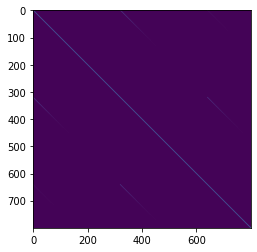

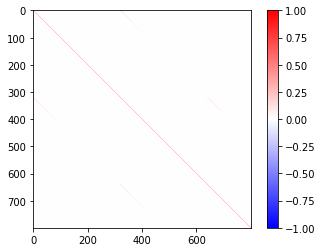

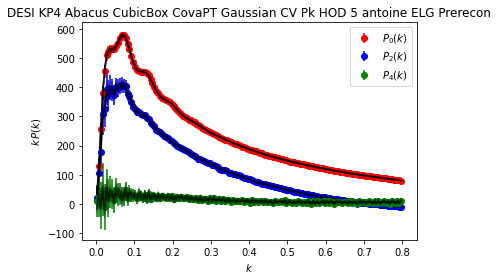

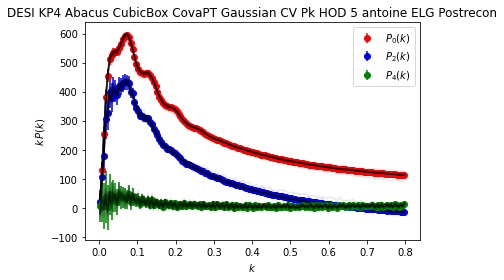

In [9]:
# Loop over tracers
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/"
path_ezmock = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/"
path_pk_cov = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/CovaPT/"
path_xi_cov = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/RascalC/"
mock = 'antoine'

# Dictionary containing z for the tracers
reds = {"ELG": [1.1]}

for hod in range(6):
    for tracer in ["ELG"]:
        for i, z in enumerate(reds[tracer]):

            # Power Spectrum --------------------------------------------------------------------------------
            # ANTOINE SETTINGS
            pre_file = path_abacus + tracer + "/Pk_CV/Pre/boryanah/"
            pre_cov_file = path_pk_cov + "AnalyticCov_Gaussian_Pk_Abacus_CubicBox_hod"+str(hod)+".txt"  
            post_file = path_abacus + tracer + "/Pk_CV/Post/boryanah/"
            post_cov_file = path_pk_cov + "AnalyticCov_Gaussian_Pk_Abacus_CubicBox_hod"+str(hod)+".txt"   
            name = f"DESI KP4 Abacus CubicBox CovaPT Gaussian CV Pk HOD " + str(hod) + ' ' + mock + ' ' + tracer 
            data = collect_pk_data(pre_file, post_file, pre_cov_file, post_cov_file, None, z, "ELG_catalog_AbacusSummit_base_c000_ph0",
                                   "ELG_AbacusSummit_base_c000_ph0", hod, name, CV=True)
            plot_pk(data) # Plot the data to check things